# Student ID: 19012516 (SORA)

# Miniproject: Modelling the climate or the weather?

Is past performance an indicator of future weather?

## Global Historial Climatology Network
GHCN (Global Historical Climatology Network)-Daily is an integrated database of daily climate summaries from land surface stations across the globe. 

THe GHCN has many datasets from weather stations across the globe. A [README describing the data form is available here](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/readme.txt). The [stations.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt) file and [countries.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt) contain information about the stations and countries.


### Machine Learning Tasks: 
1. Can you design a machine learning technique that can predict the climate (defined as the weekly or monthly average) a year in advance?  [Later in the term files containing the 2021 data will be made available
2. Can you design a machine learning technique that can predict the weather (temperature, rainfall, snow fall, etc.) any better than assuming that the weather tomorrow will be exactly the same as the weather today

### Potential extensions
1. Can you train a machine learning technique to predict 10 or 20 years into the future?
2. Where will the hotest part of the world be in 20 years time?
3. What else can you study with this dataset? Is the sun in Utah a predictor of the rain in Spain? 
4. How close do weather stations need to be to provide reliable forecasts at other stations?

### Caveats
This is real data from weather stations around the world. This means that there are 'holes' in the data. You must be able to handle these 'holes' in some error tolerant fashion.


In [ ]:
# import the urllib library
import urllib.request
from datetime import date
import numpy as np
import matplotlib.pyplot as plt 
 
#Class that keeps information about station name and location
class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country
        
    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)

#Class that hides some ugly reading routines
class GHNCD:
     
    #Class constructor
    def __init__(self): 
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)
    
    # Split up the fixed length text arrays into fields
    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip() 
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    # Process a file and extract all the information into a dictionary
    def processFile(self,fileName):
        outDict={} #
        with open(fileName, 'r') as fp: # Open file
            line = fp.readline()  #Read first line
            while line: # Process line
                fields = list(self.chunkstring(line, self.station_col_len)) #Get list of fields
                
                # For clarity use some variable names
                station=fields[0]  
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]
                # Not clear this is the only check we need, but for now
                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)
                
                #Convert missing entries to -9999 using this swishy bit of string comprehension
                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict) #Return a copy
    
    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')                  
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")
        
    
    def readStationsFile(self,fileName=None,justGSN=True):
        
        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')
            
           
            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)

    # Get all the data for a given variable type
    def getVar(self,statDict,varName='TMAX'):
        #The TMIN, TMAX, PRCP are all quoted in tenths (so need to be multipied by 0.1)
        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ]
        return tempList
    
    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')
    
    def printStation(self,sid):
        print(self.stationDict[sid])
        
    def getStation(self,sid):
        return self.stationDict[sid]
        
    def getStatKeyNames(self):
        #print(self.stationDict.keys())
        return [*self.stationDict.keys()]
        
    

In [ ]:
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

Read 219 countries and codes
Read 991 stations with justGSN True


In [ ]:
# Get list of station names
statNames=ghn.getStatKeyNames()

# Arbitrary number from 0 to 990
whichStat=220
fileName=statNames[whichStat]+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

# Copy a network object to a local file
urllib.request.urlretrieve(urlName,fileName)
statDict=ghn.processFile(fileName)
print(ghn.getStation(statNames[whichStat]))


CA002400404 is ARCTIC BAY CS, Canada at 73.0, -85.0167, 10.0


5341


Text(0, 0.5, 'Temperature (C)')

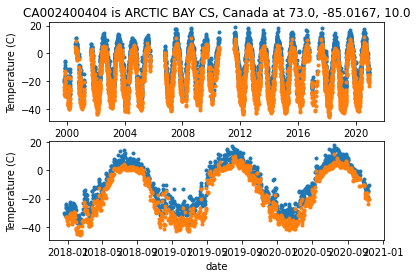

In [ ]:
tmaxArray=ghn.getVar(statDict,'TMAX')
days, tmax = zip(*tmaxArray)
tminArray=ghn.getVar(statDict,'TMIN')
days2, tmin = zip(*tminArray)
print(len(days))
fig, ax = plt.subplots(2,1)
ax[0].plot(days,tmax,'.')
ax[0].plot(days2,tmin,'.')
ax[0].set_xlabel("date")
ax[0].set_ylabel("Temperature (C)")
ax[0].set_title(ghn.getStation(statNames[whichStat]))
ax[1].plot(days[-1000:],tmax[-1000:],'.')
ax[1].plot(days2[-1000:],tmin[-1000:],'.')
ax[1].set_xlabel("date")
ax[1].set_ylabel("Temperature (C)")

## NB From here, these are student added notes and code

1. Identify the requirement (a), analyse the problem (b) and write a short introduction (c)
2. Decompose the problem into manageable sub-problems, giving a short description of what each of the sub problems will do (e.g. bulletted list).
3. Write a short explanation of the reasoning behind the decomposition.


### 1(a)
The miniproject involves developing machine learning models to predict the climate a year in advance, and to predict the weather (temperature, rainfall, snow fall, etc.) and see if this is any better than assuming that the weather tomorrow will be exactly the same as the weather today. There are a list of possible extensions in the brief, but other ones could be considered if interesting.

### 1(b)
The a large problem will be the selection, manipulation, analysis of data, and the management of gaps. The data used is from a UCL website. What is the structure of the data, what are the best ways to manipulate, analyse and deal with gaps in the data: maybe Pandas? Or is it best to stick to the above methodology? 

Once this has been resolved models can be designed to fulfil and test the requirements listed in 1(a). Models will be constructed and a training/ test set methodology designed. Models can be adapted until good and consistent results achieved. Probably LSTM models will be used as these seem well suited to making predictions with sequential and periodic data like coursework examples (double pendulum and sunspots).

Extension projects (time allowing) will be decided based on what data is available and with consideration of interesting areas to investigate.

### 1(c)
The aim of this project was to see if machine learning techniques could be applied successfully to weather and climate forecasting. Data used was from the Global Historical Climatology Network (GCHN): a series of weather stations around the world. Analysis of the data, best methods of parsing and cleaning it were made. Predictive machine learning models were developed and trained.

As an area of intersting further research and after checking adequate data was available, studies were made into the effect of using data from neighbouring stations to improve weather predictions, as well as exploring the effects of changing other parameters.

### 2 - Decompose the problem into manageable sub-problems, giving a short description of what wach of the sub problems will do (e.g. bulletted list).
I. Review code provided, investigate extent and quality of UCL data.
<p>II. Determine how to parse, clean and manipulate data, try to use Pandas.
<p>III. Determine which station(s) to use for the two main machine learning tasks (climate, weather).
<p>IV. Determine the training/ validation/ test methodology, probably using Sklearn.
<p>V. Decide upon models, review course materials- especially those using RNN models, e.g. LSTM. Week6_pandas.ipynb will be very relevant as uses Pandas, Sklearn and deals with multi-year periodic data (sunspots). Also the double pendulum exercise is relevant as it used models that input and output several features.
<p>VI. Conduct climate prediction experiments.
<p>VII. Conduct weather prediction experiments.
<p>VIII. Decide on an extention project (hopefully to integrate extra elements and data from several stations).
<p>IX. Check the notebook for any opportunities to simplify. Make sure to annotate fully and with supporting text cells.
<p>X. Write report.
<p>XI. Review notebook and reports for any errors and submit.

### 3 - Write a short explanation of the reasoning behind the decomposition.
The purpose of the decompostion was to break the project down into manageable parts. The ordering is very important: first one needs to understand the code already supplied and the data available. Once a methodology for dealing with the data has been determined, the training methodology and the model can be designed, then run. The extension projects are very dependent on what data is available which was not known at the outset.  




## Task I: Review code and investigate extent and quality of UCL data.
<p>UCL webpages are text files with UTF-8 encoding. Each line of a text file contains a record from which fields can be extracted as they are each of a fixed column width. For example:

http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt
<p>This contains just a country code in the first two columns then a space and then a country name from the fourth column to the end. The file is made up of 219 rows, which is what has been extracted in the given code.
They have been extracted using these column lengths into a dictionary object called "countryDict".

http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt
<p>The above file contains the station details. There are 115074 in the file, but only 991 of these are extracted in the above code. There is a field "gsn" which is either blank or contains 'GSN'. According to documentation, this is a flag which says whether a station is part of GCOS Surface Network (GSN), a subset of GHCN.
<p>According to:

https://www.ncdc.noaa.gov/gosic/global-climate-observing-system-gcos/gcos-surface-network-gsn-program-overview
<p>"The GCOS Surface Network (GSN) is a baseline network comprising a subset of about 1000 stations chosen mainly to give a fairly uniform spatial coverage from places where there is a good length and quality of data record."
<p>It seems sensible to start using just these 991 stations as they should provide plenty of quality data from stations well spaced across the globe. The key fields are:  

<p>ID: unique identifier of station
<p>LATITUDE: latitude of the station (in decimal degrees)
<p>LONGITUDE: longitude of the station (in decimal degrees)
<p>ELEVATION: elevation of the station (in meters, missing = -999.9)   
<p>NAME: is station name
<p>GSN FLAG: blank or 'GSN'

These fields and all others are extracted into the dictionary "stationDict". NB it is easy to relax the constraint to only include GSN stations as demonstrated below:


In [ ]:
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile(justGSN=False)

Read 219 countries and codes
Read 115074 stations with justGSN False


## Task I continued
http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/
<p>The above link provides the index of .dly files which contain the meteorological measurements for each station. Each file is named with the station ID, e.g. AE000041196.dly is the first one. There are 991 stations listed, i.e. corresponding to the GSN stations. For measurements from other stations, access to other data sources would be required. 

Each row in a file is a record containing one month of daily data for a particular type of measurement or "element".  The variables on each line include the following (and are at fixed column positions):

<p>ID: Station ID
<p>YEAR: e.g. 1944
<p>MONTH: e.g. 03 for March
<p>ELEMENT: There are many elements possible, but the five core ones are: 
<p>PRCP = Precipitation (in tenths of mm)
<p>SNOW = Snowfall (mm)
<p>SNWD = Snow depth (mm)
<p>TMAX = Maximum temperature (tenths of degrees C)
<p>TMIN = Minimum temperature (tenths of degrees C)
<p>By inspection of the first .dly file for the first GSN station, "SHARJAH INTER. AIRP" in United Arab Emirates, it is not surprising that there is no mention of "SNOW" or "SNWD" elements. "TAVG" for average temperature features regularly, but often data is not available. Missing data is recorded as "-9999". 
<p>VALUE1: value of this element on the first day of the month
<p>Then follows three flags: MFLAG1, QFLAG1, SFLAG1. These are each single column items. 
<p>MFLAG1 - describes measurement methodologies. If left blank, normal measurements were taken otherwise a code is given, e.g. B = precipitation total formed from two 12-hour totals.
<p>These look like they just explain how measurements were taken and it was assumed that they should not affect overall data quality.
<p>QFLAG1 - describes quality of measurement, and quality is fine if it left blank. Here the items that appear are more serious and may require exclusion or replacement of data, e.g. I = failed internal consistency check.
<p>SFLAG1 - describes the source of the data, e.g. "U.S. Cooperative Summary of the Day (NCDC DSI-3200)". Unless one has knowledge of the different agencies, it was assumed that this field is less important from a data quality point of view as it is presumed that GSN is only using reputable sources for data.
These three flags are repeated for 31 days in the month in question, i.e. VALUE2, MFLAG2, QFLAG2, SFLAG2....VALUE31, MFLAG31, QFLAG31, SFLAG31. For months with less than 31 days, e.g. April, the missing days will be recorded with -9999 in VALUE field and blanks in the others.

Reviewing the supplied code, the data has been extracted using the known column widths. 

In [ ]:
print(statDict)

{'TMAX': {'monthList': [{'year': 1999, 'month': 11, 'field': 'TMAX', 'vals': [-9999, -9999, -9999, -9999, -9999, -186, -205, -203, -248, -198, -66, -56, -104, -147, -218, -87, -108, -128, -108, -130, -167, -201, -216, -189, -189, -257, -266, -194, -168, -194, -9999], 'flags': ['', '', '', '', '', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', '']}, {'year': 2000, 'month': 2, 'field': 'TMAX', 'vals': [-119, -113, -167, -221, -258, -259, -259, -308, -320, -319, -271, -281, -307, -319, -313, -237, -273, -252, -212, -164, -187, -215, -227, -289, -275, -274, -311, -316, -331, -9999, -9999], 'flags': ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', '', '']}, {'year': 2000, 'month': 3, 'field': 'TMAX', 'vals': [-340, -336, -332, -260, -268, -265, -299, -261, -265, -283, -288, -275, -275, -251, -266, -294, -297, -233, -22

## Task II. Determine how to parse, clean and manipulate data.
The data for each station is extracted as a dictionary *statDict* which has a complicated structure where each ELEMENT is a dictionary entry, with values which are a list of months for that ELEMENT. This is itself a list of dictionaries ...


In [ ]:
#Key library imports and parameters to be used in this notebook
import urllib.request
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [12,10]
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [ ]:
#Try to construct dataframe from statDict
dly = pd.DataFrame.from_dict(statDict, orient='columns', dtype=None, columns=None)

#display head of dataframe
dly.head()

,TMAX,TMIN,PRCP,SNOW,SNWD,TAVG,WDFG,WSFG
monthList,"[{'year': 1999, 'month': 11, 'field': 'TMAX', ...","[{'year': 1999, 'month': 11, 'field': 'TMIN', ...","[{'year': 1999, 'month': 11, 'field': 'PRCP', ...","[{'year': 1999, 'month': 11, 'field': 'SNOW', ...","[{'year': 2000, 'month': 8, 'field': 'SNWD', '...","[{'year': 2003, 'month': 6, 'field': 'TAVG', '...","[{'year': 2015, 'month': 4, 'field': 'WDFG', '...","[{'year': 2015, 'month': 4, 'field': 'WSFG', '..."


## Task II. continued
This information would have to be unpacked. Instead, it was decided to test and adapt some code found on Dr. Ned Haughton's GitHub pages. This read the underlying data directly into Pandas dataframes (see code below with adaptions made to fit the needs of this experiment). The code was available on 20 December 2021, but has subsequently been removed from github. Dr. Ned Haughton works as a risk analyst at a firm called Climate Risk Property Ltd. and obtained a PhD in Climate Science from the University of New South Wales in Australia (according to LinkedIn).

https://github.com/nedclimaterisk

In [ ]:
#Code is adapted from Dr. Ned Haughton's GitHub Site
#This was accessed on 20 December 2021
#But code has been removed subsequently
#https://github.com/nedclimaterisk
#Changes made were:
# 1. Added a DataFrame for Countries.
# 2. Changed File/ Filename references to ucl urls.
# 3. Stations DataFrame was adapted to select only GCN (default) or all stations.
# 4. Changed a reference of pd.np to np. as numpy installed and to remove a deprecation warning message
# 5. Multiplied TMAX, TMIN, TAVG, PRCP values by 0.1 in line with given code
# 6. Removed option to not display FLAGS, as important to show them
# 7. However, added an option to exclude SFLAG (default) - as not important for data quality
#    Makes viewing DataFrame easier as reduces columns

#Extract a Dataframe for Countries
country_col_specs = [
    (0,  2),
    (3, 64)]

country_names = [
    "ID",
    "COUNTRY"]

country_dtype = {
    "ID": str,
    "COUNTRY": str}

def read_countries(fileName=None):
  if fileName==None:
    file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
  else:
    file = open(fileName,'r')
  df = pd.read_fwf(file, country_col_specs, names=country_names,
                     index_col='ID', dtype=country_dtype)

  return df

#Extract a Dataframe for Stations
station_col_specs = [
    (0,  12),
    (12, 21),
    (21, 31),
    (31, 38),
    (38, 41),
    (41, 72),
    (72, 76),
    (76, 80),
    (80, 86)]

station_names = [
    "ID",
    "LATITUDE",
    "LONGITUDE",
    "ELEVATION",
    "STATE",
    "NAME",
    "GSN FLAG",
    "HCN/CRN FLAG",
    "WMO ID"]

station_dtype = {
    "ID": str,
    "STATE": str,
    "NAME": str,
    "GSN FLAG": str,
    "HCN/CRN FLAG": str,
    "WMO ID": str
    }

def read_stations(fileName=None, justGSN=True):
    if fileName==None:
      file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
    else:
      file = open(fileName,'r')
    df = pd.read_fwf(file, station_col_specs, names=station_names,
                     index_col='ID', dtype=station_dtype)
    if justGSN: df = df[df['GSN FLAG'] == 'GSN']# selects only rows with GSN FLAG as 'GSN'

    return df

#Extract a Dataframe for Weather Data from a Station
data_header_names = [
    "ID",
    "YEAR",
    "MONTH",
    "ELEMENT"]

data_header_col_specs = [
    (0,  11),
    (11, 15),
    (15, 17),
    (17, 21)]

data_header_dtypes = {
    "ID": str,
    "YEAR": int,
    "MONTH": int,
    "ELEMENT": str}

data_col_names = [[
    "VALUE" + str(i + 1),
    "MFLAG" + str(i + 1),
    "QFLAG" + str(i + 1),
    "SFLAG" + str(i + 1)]
    for i in range(31)]
# Join sub-lists
data_col_names = sum(data_col_names, [])

data_replacement_col_names = [[
    ("VALUE", i + 1),
    ("MFLAG", i + 1),
    ("QFLAG", i + 1),
    ("SFLAG", i + 1)]
    for i in range(31)]
# Join sub-lists
data_replacement_col_names = sum(data_replacement_col_names, [])
data_replacement_col_names = pd.MultiIndex.from_tuples(
    data_replacement_col_names,
    names=['VAR_TYPE', 'DAY'])

data_col_specs = [[
    (21 + i * 8, 26 + i * 8),
    (26 + i * 8, 27 + i * 8),
    (27 + i * 8, 28 + i * 8),
    (28 + i * 8, 29 + i * 8)]
    for i in range(31)]
data_col_specs = sum(data_col_specs, [])

data_col_dtypes = [{
    "VALUE" + str(i + 1): int,
    "MFLAG" + str(i + 1): str,
    "QFLAG" + str(i + 1): str,
    "SFLAG" + str(i + 1): str}
    for i in range(31)]
data_header_dtypes.update({k: v for d in data_col_dtypes for k, v in d.items()})

def read_ghcn_data_file(filename='CA002400404.dly',
                        variables=None,
                        dropna='all', include_SFLAG = False):
    """Reads in all data from a GHCN .dly data file

    :param filename: path to file
    :param variables: list of variables to include in output dataframe
        e.g. ['TMAX', 'TMIN', 'PRCP']
    :param include_SFLAG: Whether to include SFLAG in the final output
    :returns: Pandas dataframe
    """
    urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+filename
    urllib.request.urlretrieve(urlName,filename)
    df = pd.read_fwf(
        filename,
        colspecs=data_header_col_specs + data_col_specs,
        names=data_header_names + data_col_names,
        index_col=data_header_names,
        dtype=data_header_dtypes
        )

    if variables is not None:
        df = df[df.index.get_level_values('ELEMENT').isin(variables)]

    df.columns = data_replacement_col_names
    
    df = df.stack(level='DAY').unstack(level='ELEMENT')

    if dropna:
        df.replace(-9999.0, np.nan, inplace=True)
        df.dropna(how=dropna, inplace=True)

    # replace the entire index with the date.
    # This loses the station ID index column!
    # This will usually fail if dropna=False, since months with <31 days
    # still have day=31 columns
    df.index = pd.to_datetime(
        df.index.get_level_values('YEAR') * 10000 +
        df.index.get_level_values('MONTH') * 100 +
        df.index.get_level_values('DAY'),
        format='%Y%m%d')

    #Multiply temp and precipitation by 0.1 as in example code
    #'If' statements allow for possibility that DataFrame doesn't include
    #these columns. Use of '.loc' methodology adapted from:
    #https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
    if 'PRCP' in df['VALUE']: df.loc[:, ('VALUE', 'PRCP')] = 0.1 * df.loc[:, ('VALUE', 'PRCP')]
    if 'TMIN' in df['VALUE']: df.loc[:, ('VALUE', 'TMIN')] = 0.1 * df.loc[:, ('VALUE', 'TMIN')]
    if 'TMAX' in df['VALUE']: df.loc[:, ('VALUE', 'TMAX')] = 0.1 * df.loc[:, ('VALUE', 'TMAX')]
    if 'TAVG' in df['VALUE']: df.loc[:, ('VALUE', 'TAVG')] = 0.1 * df.loc[:, ('VALUE', 'TAVG')]

    
    #Remove SFLAG column if specified
    if not include_SFLAG:
      df.drop('SFLAG', axis = 1, inplace = True)
    
    


    return df


## Task II. continued
The following code cell extracts the daily data for the example station into a dataframe and outputs it.

In [ ]:
filename = 'CA002400404.dly'
dly = read_ghcn_data_file(filename=filename)
dly

VAR_TYPE   MFLAG                           ... VALUE                               
ELEMENT     PRCP SNOW SNWD TAVG TMAX TMIN  ...  SNWD  TAVG  TMAX  TMIN  WDFG   WSFG
1999-11-01   NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN    NaN
1999-11-02   NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN    NaN
1999-11-03   NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN    NaN
1999-11-04   NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN    NaN
1999-11-05   NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   NaN    NaN
...          ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   ...   ...    ...
2020-11-10   NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN -15.8 -11.3 -20.3  16.0  620.0
2020-11-11   NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN -21.1 -18.6 -23.5   NaN    NaN
2020-11-12   NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN -17.8 -14.7 -20.9   NaN    NaN
2020-11-13   NaN  NaN  NaN  NaN  NaN  NaN  ...  20.0 -17.9 -14.5 -21.3   8.0  450.0
2020-11-14   NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN -15.6 -10.7 -20.4   8.0  560.0

[6130 rows x 24 columns]

## Task II. continued
There are lots of NaN's. This does not matter in flag columns, in fact it is good, as it signals that these is no issue with the data. However NaN in the VALUE columns suggests incomplete data.

In [ ]:
dly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6130 entries, 1999-11-01 to 2020-11-14
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (MFLAG, PRCP)  0 non-null      float64
 1   (MFLAG, SNOW)  0 non-null      float64
 2   (MFLAG, SNWD)  199 non-null    object 
 3   (MFLAG, TAVG)  3309 non-null   object 
 4   (MFLAG, TMAX)  0 non-null      float64
 5   (MFLAG, TMIN)  0 non-null      float64
 6   (MFLAG, WDFG)  0 non-null      float64
 7   (MFLAG, WSFG)  0 non-null      float64
 8   (QFLAG, PRCP)  3 non-null      object 
 9   (QFLAG, SNOW)  1 non-null      object 
 10  (QFLAG, SNWD)  2 non-null      object 
 11  (QFLAG, TAVG)  0 non-null      float64
 12  (QFLAG, TMAX)  0 non-null      float64
 13  (QFLAG, TMIN)  1 non-null      object 
 14  (QFLAG, WDFG)  0 non-null      float64
 15  (QFLAG, WSFG)  0 non-null      float64
 16  (VALUE, PRCP)  3378 non-null   float64
 17  (VALUE, SNOW)  760 non-null    flo

## Task II. continued
As expected, lots of null values in the VALUE columns. How can we visualise this? The following code has been adapted from material contained in a lecture series "Data Science & Machine Learning Bootcamp" available on Skillshare by Dr. Junaid Qazi. The lectures were especially useful to learn how to manipulate data with Pandas and to visualise data (e.g. in the example below using a seaborn heatmap.)

Firstly, for VALUE columns:

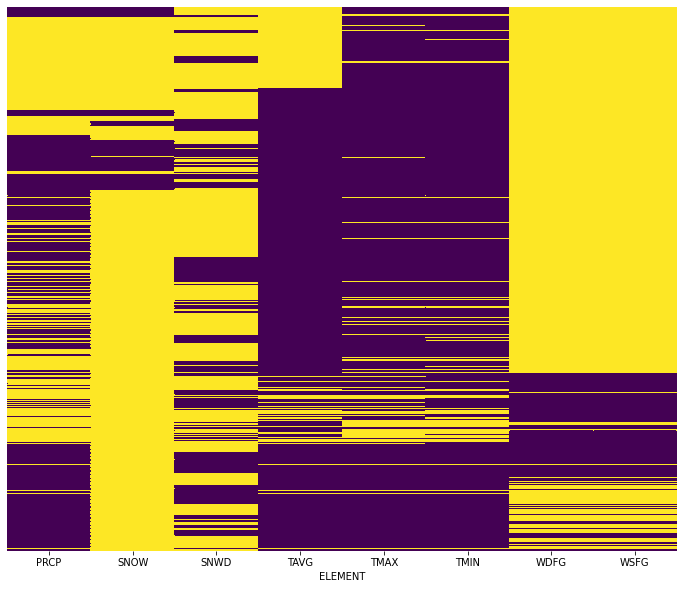

In [ ]:
#adapted from "Data Science & Machine Learning Bootcamp"
#"Class 6 of 10 - Linear Regression, Logistic Regression"
#By Dr. Junaid Qazi, available on SkillShare
#NB dates are not shown on y axis for clarity
#yellow areas have null data, purple areas are populated
sns.heatmap(data=dly['VALUE'].isnull(), yticklabels=False, cbar = False, cmap ='viridis');

## Task II. continued
Next for MFLAG and QFLAG columns

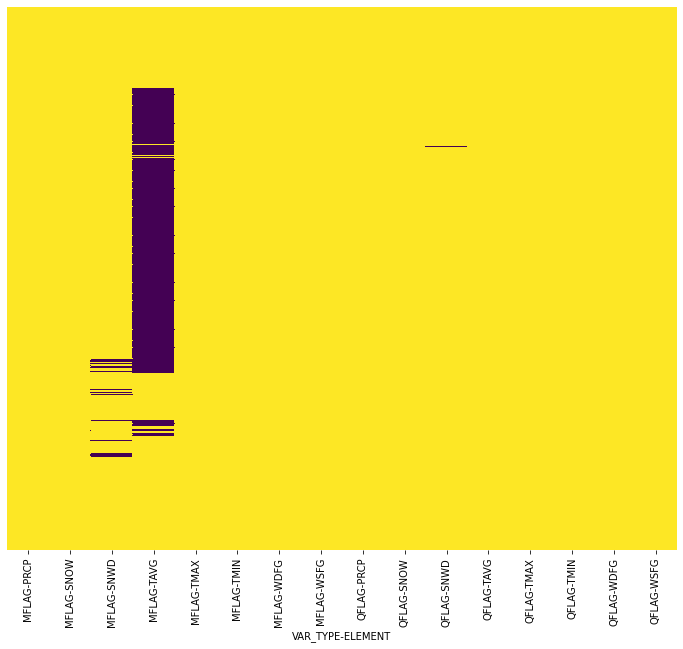

In [ ]:
sns.heatmap(data=dly[['MFLAG', 'QFLAG']].isnull(), yticklabels=False, cbar = False, cmap ='viridis');

## Task II. continued
Overall, this was a poor data set with many missing data in VALUES columns even for the main 5 elements. However, the analysis was useful and it was decided to continue to use the new method of extraction of GHCN data into Pandas dataframes. 
<p>
<p>

## Task III. Determine which station(s) to use for the two main machine learning tasks (climate, weather).

Rather than manually looking through all 991 stations one by one, it was decided to loop through the different stations and to open their .dly files. From this, relevant fields could be recorded and then a new dataframe could be made to include more columns onto to the following stations dataframe (shown below).

In [ ]:
stations = read_stations()
stations

,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
ID,,,,,,,,
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196
AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930
AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390
AG000060590,30.5667,2.8667,397.0,NaN,EL-GOLEA,GSN,NaN,60590
AG000060611,28.0500,9.6331,561.0,NaN,IN-AMENAS,GSN,NaN,60611
...,...,...,...,...,...,...,...,...
ZA000067633,-15.2500,23.1500,1053.0,NaN,MONGU,GSN,NaN,67633
ZA000067743,-17.8170,25.8170,986.0,NaN,LIVINGSTONE,GSN,NaN,67743
ZI000067775,-17.9170,31.1330,1480.0,NaN,HARARE (KUTSAGA),GSN,NaN,67775


## Task III continued
It was decided that the new data should contain measures of length, completeness and quality of data for the five main elements. To this, a measure of the broadness of the dataset was added by considering the total number of elements. With this in mind, the following columns were to be added: 

<p>start: date where .dly starts. The earlier the better.
<p>end: date where .dly ends. The latter the better.
<p>n_ELEM: number of elements. The more the better it as gives a broader dataset.
<p>TMAX_start, TMIN_start, PRCP_start, SNOW_start, SNWD_start: date where these start as often different from 'start'. The earlier the better.
<p>TMAX_comp, TMIN_comp, PRCP_comp, SNOW_comp, SNWD_comp: Actual datapoints (i.e. not null) as a proportion from start date of each element. Best value 1, worst 0.
<p>TMAX_q, TMIN_q, PRCP_q, SNOW_q, SNWD_q: proportion of datapoints without a QFLAG value. Best value 1, worst 0.

In [ ]:
#Make new_stations DataFrame
#Cell takes a long time to run c40 mins.
#new_stations is converted to a .pkl file and downloaded to local computer.
#This .pkl file can be uploaded if necessary so cell does not need to be re-run
#Apart from adapting an example of dynamic variables within loops, from codegepper.com
#this is student written code. 

#headings of columns to be added
column_headings = ['start', 'end', 'n_ELEM', 'TMAX_start', 'TMIN_start', 
                   'PRCP_start', 'SNOW_start', 'SNWD_start', 'TMAX_comp', 'TMIN_comp', 
                   'PRCP_comp', 'SNOW_comp', 'SNWD_comp', 'TMAX_q', 'TMIN_q', 
                   'PRCP_q', 'SNOW_q', 'SNWD_q']
                   
#array to add new data to for each station
extra_data = []#empty list

#loop through all 991 station.
#tested using stations.iloc[0:3].index in place of stations.index
# useful as found first station didn't have SNOW, SNWD data (in UAE!) 
for i in stations.index:
  
  #open and read daily file for station i
  filename = i+'.dly'
  dly = read_ghcn_data_file(filename=filename)
  
  #calculate the required variables
  start = dly.index.min()
  end = dly.index.max()
  n_ELEM = len(dly['VALUE'].columns)
  
  #dynamic variable within loop adapted from 
  #https://www.codegrepper.com/code-examples/python/dynamically+create+variables+in+loop+python
  for i in ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD']:
    
    if i in dly['VALUE']: #where .dly file contains the relevant data columns
      #start date of each element i
      globals()[f"{i}_start"] = dly[dly['VALUE'][i].notnull() == True].index.min()
  
      #how complete data is from start date (from 0 to 100%)
      globals()[f"{i}_comp"] = 1- dly.loc[globals()[f"{i}_start"]:end, ('VALUE', i)].isna().sum()/ dly.loc[globals()[f"{i}_start"]:end].shape[0]
  
      #quality of data from start date: 100% means no quality flags (good), 0% means all quality flags (bad)
      globals()[f"{i}_q"] = dly.loc[globals()[f"{i}_start"]:end, ('QFLAG', i)].isna().sum()/ dly.loc[globals()[f"{i}_start"]:end].shape[0]

    else: #where dly does not contain data, e.g. SNOW in UAE based station
      globals()[f"{i}_start"] = np.nan
      globals()[f"{i}_comp"] = np.nan
      globals()[f"{i}_q"] = np.nan

  #collect calculated variables in a list
  new_data = [start, end, n_ELEM, TMAX_start, TMIN_start, 
              PRCP_start, SNOW_start, SNWD_start, TMAX_comp, TMIN_comp, 
              PRCP_comp, SNOW_comp, SNWD_comp, TMAX_q, TMIN_q, 
              PRCP_q, SNOW_q, SNWD_q]

  #append to existing data
  extra_data.append(new_data)

#make dataframe from extra_data
new_stations = pd.DataFrame(data=extra_data, index = stations.index, columns = column_headings)

#save it as takes a long time to generate c.40 mins
new_stations.to_pickle("./new_stations.pkl")
files.download("new_stations.pkl")

#display dataset
new_stations

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,start,end,n_ELEM,TMAX_start,TMIN_start,PRCP_start,SNOW_start,SNWD_start,TMAX_comp,TMIN_comp,PRCP_comp,SNOW_comp,SNWD_comp,TMAX_q,TMIN_q,PRCP_q,SNOW_q,SNWD_q
ID,,,,,,,,,,,,,,,,,,
AE000041196,1944-03-20,2020-11-13,4,1944-03-20,1944-03-20,1944-03-20,NaT,NaT,0.764022,0.630496,0.143737,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN
AF000040930,1973-01-13,1992-04-21,5,1973-11-27,1974-02-18,1988-03-24,NaT,1982-01-01,0.508785,0.590624,0.009756,NaN,0.510242,0.999634,0.999631,1.000000,NaN,0.999069
AG000060390,1940-01-01,2020-11-13,5,1940-01-01,1940-01-01,1940-01-01,NaT,2005-01-26,0.893631,0.897393,0.879902,NaN,0.000348,0.999424,0.999424,1.000000,NaN,1.000000
AG000060590,1892-01-01,2020-11-13,5,1892-01-01,1892-01-01,1892-01-01,NaT,2010-10-31,0.828442,0.941883,0.885951,NaN,0.000276,0.979807,0.979807,0.980692,NaN,0.999724
AG000060611,1958-10-01,2020-11-13,5,1958-10-01,1958-10-01,1958-10-01,NaT,1985-01-13,0.890235,0.929181,0.865346,NaN,0.000153,0.999691,0.999691,1.000000,NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZA000067633,1956-01-01,2014-02-12,5,1973-08-05,1973-08-05,1956-01-01,NaT,1982-04-26,0.200089,0.326609,0.967449,NaN,0.000276,1.000000,1.000000,1.000000,NaN,0.999724
ZA000067743,1950-01-01,2020-11-02,4,1973-07-30,1973-01-16,1950-01-01,NaT,NaT,0.234295,0.346613,0.869469,NaN,NaN,0.999886,0.999888,1.000000,NaN,NaN
ZI000067775,1956-07-01,2020-10-30,5,1956-07-01,1956-07-01,1956-07-01,NaT,1999-09-27,0.848166,0.852004,0.656654,NaN,0.000286,0.999777,0.999821,1.000000,NaN,1.000000


In [ ]:
#Run this cell if you need to recover new_stations. Code adapted from:
#https://colab.research.google.com/notebooks/io.ipynb#scrollTo=p2E4EKhCWEC5
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
new_stations = pd.read_pickle("./new_stations.pkl")

Saving new_stations.pkl to new_stations.pkl
User uploaded file "new_stations.pkl" with length 157874 bytes


In [ ]:
#create a complete DataFrame concatenating stations and new_stations DataFrames
stations_comp = pd.concat([new_stations, stations], axis =1)
stations_comp

,start,end,n_ELEM,TMAX_start,TMIN_start,PRCP_start,SNOW_start,SNWD_start,TMAX_comp,TMIN_comp,PRCP_comp,SNOW_comp,SNWD_comp,TMAX_q,TMIN_q,PRCP_q,SNOW_q,SNWD_q,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
ID,,,,,,,,,,,,,,,,,,,,,,,,,,
AE000041196,1944-03-20,2020-11-13,4,1944-03-20,1944-03-20,1944-03-20,NaT,NaT,0.764022,0.630496,0.143737,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196
AF000040930,1973-01-13,1992-04-21,5,1973-11-27,1974-02-18,1988-03-24,NaT,1982-01-01,0.508785,0.590624,0.009756,NaN,0.510242,0.999634,0.999631,1.000000,NaN,0.999069,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930
AG000060390,1940-01-01,2020-11-13,5,1940-01-01,1940-01-01,1940-01-01,NaT,2005-01-26,0.893631,0.897393,0.879902,NaN,0.000348,0.999424,0.999424,1.000000,NaN,1.000000,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390
AG000060590,1892-01-01,2020-11-13,5,1892-01-01,1892-01-01,1892-01-01,NaT,2010-10-31,0.828442,0.941883,0.885951,NaN,0.000276,0.979807,0.979807,0.980692,NaN,0.999724,30.5667,2.8667,397.0,NaN,EL-GOLEA,GSN,NaN,60590
AG000060611,1958-10-01,2020-11-13,5,1958-10-01,1958-10-01,1958-10-01,NaT,1985-01-13,0.890235,0.929181,0.865346,NaN,0.000153,0.999691,0.999691,1.000000,NaN,1.000000,28.0500,9.6331,561.0,NaN,IN-AMENAS,GSN,NaN,60611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZA000067633,1956-01-01,2014-02-12,5,1973-08-05,1973-08-05,1956-01-01,NaT,1982-04-26,0.200089,0.326609,0.967449,NaN,0.000276,1.000000,1.000000,1.000000,NaN,0.999724,-15.2500,23.1500,1053.0,NaN,MONGU,GSN,NaN,67633
ZA000067743,1950-01-01,2020-11-02,4,1973-07-30,1973-01-16,1950-01-01,NaT,NaT,0.234295,0.346613,0.869469,NaN,NaN,0.999886,0.999888,1.000000,NaN,NaN,-17.8170,25.8170,986.0,NaN,LIVINGSTONE,GSN,NaN,67743
ZI000067775,1956-07-01,2020-10-30,5,1956-07-01,1956-07-01,1956-07-01,NaT,1999-09-27,0.848166,0.852004,0.656654,NaN,0.000286,0.999777,0.999821,1.000000,NaN,1.000000,-17.9170,31.1330,1480.0,NaN,HARARE (KUTSAGA),GSN,NaN,67775


## Task III continued
This larger dataframe could be filtered down using boolean masks to show only those with the best data, as shown in the following cell.

In [ ]:
#filter down to only stations with 'best data'
#i.e. longest, most complete, highest quality and broadest

#Filter 1. End date after 30/10/2020
stations_filt = stations_comp[stations_comp['end']>pd.to_datetime('30/10/2020')]

#Filter 2. Exclude those with no SNOW data sets as probably have more varied climates
stations_filt = stations_filt[stations_filt['SNOW_start'].notnull() == True]

#Filter 3. Exclude those with no SNWD data sets as above
stations_filt = stations_filt[stations_filt['SNWD_start'].notnull() == True]

#Filter 4. Exclude those with the least complete temp data, e.g. TMAX_comp <0.995
stations_filt = stations_filt[stations_filt['TMAX_comp'] >= 0.995]

#Filter 5. Exclude those with the lowest quality temp data, e.g. TMAX_q <0.999
stations_filt = stations_filt[stations_filt['TMAX_q'] >= 0.999]

#Filter 6. Exclude those with the least complete SNOW data, e.g. SNOW_comp <0.99
stations_filt = stations_filt[stations_filt['SNOW_comp'] >= 0.99]



stations_filt

,start,end,n_ELEM,TMAX_start,TMIN_start,PRCP_start,SNOW_start,SNWD_start,TMAX_comp,TMIN_comp,PRCP_comp,SNOW_comp,SNWD_comp,TMAX_q,TMIN_q,PRCP_q,SNOW_q,SNWD_q,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
ID,,,,,,,,,,,,,,,,,,,,,,,,,,
CA003081680,1952-12-01,2020-11-14,8,1952-12-01,1952-12-01,1953-05-01,1953-05-01,1955-01-01,0.997014,0.997054,0.997118,0.997118,0.940606,1.000000,1.000000,1.000000,0.999026,0.998085,54.4167,-110.2833,541.0,AB,COLD LAKE A,GSN,NaN,71120
CA008501900,1941-12-01,2020-11-14,8,1941-12-01,1941-12-01,1941-12-01,1941-12-01,1955-01-01,0.997676,0.997676,0.997746,0.997746,0.954018,0.999965,1.000000,1.000000,0.999445,0.998670,53.3167,-60.4167,49.0,NL,GOOSE A,GSN,NaN,71816
FMW00040308,1941-11-03,2020-11-13,41,1951-07-01,1951-07-01,1951-07-01,1951-07-01,1951-07-01,0.999921,0.999921,0.999921,0.991002,0.992186,0.999882,0.999961,1.000000,1.000000,1.000000,9.4833,138.0833,13.4,FM,YAP ISLAND WSO AP,GSN,NaN,91490
FMW00040504,1949-11-30,2020-11-13,36,1951-07-01,1951-07-01,1951-07-01,1951-07-01,1951-07-01,1.000000,1.000000,1.000000,0.995343,0.996566,0.999961,1.000000,0.999645,1.000000,1.000000,6.9667,158.2167,36.6,FM,POHNPEI WSO,GSN,NaN,91348
FMW00040505,1945-12-31,2020-11-13,32,1951-07-01,1951-07-01,1951-07-01,1951-07-01,1951-07-01,0.999960,0.999920,0.999801,0.994534,0.994454,1.000000,1.000000,0.999960,1.000000,1.000000,7.4500,151.8333,1.5,FM,CHUUK WSO AP,GSN,NaN,91334
GQW00041415,1957-03-01,2020-11-14,37,1957-03-01,1957-03-01,1957-03-01,1957-03-01,1957-03-01,0.999742,0.999914,0.999828,0.998582,0.998496,1.000000,1.000000,0.999570,1.000000,1.000000,13.4836,144.7961,77.4,GU,GUAM INTL AP,GSN,NaN,91212
RQW00011641,1941-06-17,2020-11-13,38,1956-01-01,1956-01-01,1956-01-01,1956-01-01,1956-01-01,0.999916,0.999916,0.999873,0.992022,0.993626,1.000000,1.000000,1.000000,1.000000,1.000000,18.4325,-66.0108,2.7,PR,SAN JUAN L M MARIN AP,GSN,NaN,78526
USW00003870,1962-10-15,2020-11-14,45,1962-10-15,1962-10-15,1962-10-15,1962-10-15,1962-10-15,1.000000,1.000000,1.000000,0.998067,0.998397,1.000000,1.000000,1.000000,1.000000,1.000000,34.8831,-82.2203,286.5,SC,GREER,GSN,HCN,72312
USW00003945,1969-11-01,2020-11-14,45,1969-11-01,1969-11-01,1969-11-01,1969-11-01,1969-11-01,0.997434,0.997325,0.997380,0.999618,0.989246,1.000000,1.000000,1.000000,0.999945,0.999836,38.8169,-92.2183,272.2,MO,COLUMBIA RGNL AP,GSN,NaN,72445


## Task III continued

### Selected dataset from 26 stations in shortlist:
<p>USW00023066: GRAND JUNCTION WALKER FLD, CO., USA. It has the longest data (since 1900), with a perfect quality score for all variables, and completeness for each of the five main elements is 0.9998 or above. A continental climate is likely, so high temperature variations and snow is expected. It is also one of the broadest datasets with 60 elements.

### Backups, or for extension projects:
<p>USW00026411: FAIRBANKS INTL AP, AK, USA. Long data set (1929). Near perfect quality and completeness scores. Different situation to Colorado, might be interesting comparison.
<p>FMW00040308: YAP ISLAND WSO AP, Pacific Ocean. Might be an interesting contrast. Long data set (1951) and good completeness and quality.

### Investigate selected dataset
Before designing the model, the date needed to be investigated and filled if necessary.

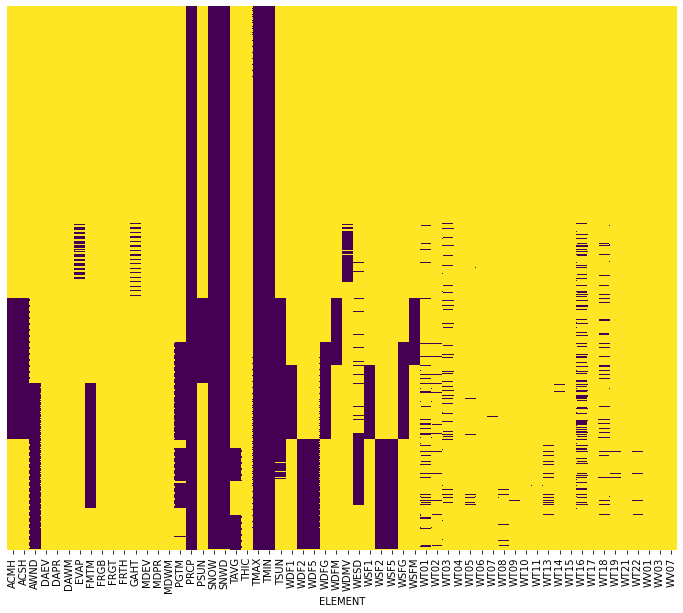

In [ ]:
filename = 'USW00023066.dly'
dly = read_ghcn_data_file(filename=filename)
sns.heatmap(data=dly['VALUE'].isnull(), yticklabels=False, cbar = False, cmap ='viridis');

## Task III. continued

Very good completeness for the five main elements and, as we already saw, perfect quality scores for all of these.
<p>Some other interesting but shorter elements are available, e.g.:
<p>AWND - Average daily wind speed
<p>WDF2 - Direction of fastest 2-minute wind (degrees)
<p>WDF5 - Direction of fastest 5-second wind (degrees)
<p>WSF2 - Fastest 2-minute wind speed (tenths of meters per second)
<p>WSF5 - Fastest 5-second wind speed (tenths of meters per second)

For the climate experiment, it was decided to use monthly data and therefore long datasets would be better. Thus it was decided to reduce down to the core five elements in a datadrame "dly_5".

<p>There were no quality issues, just the value data was extracted.

In [ ]:
filename = 'USW00023066.dly'
dly = read_ghcn_data_file(filename=filename)

#drop MFLAG and QFLAG column
dly.drop(('MFLAG'), axis = 1, inplace = True)
dly.drop(('QFLAG'), axis = 1, inplace = True)

#drop VAR_TYPE column hierarchy as no longer needed 
dly_5 = dly.droplevel('VAR_TYPE',axis= 1)

#select the desired 5 columns
dly_5 = dly_5[['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD']]

#check on missing data
dly_5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44122 entries, 1900-01-01 to 2020-11-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    44118 non-null  float64
 1   TMIN    44113 non-null  float64
 2   PRCP    44115 non-null  float64
 3   SNOW    44119 non-null  float64
 4   SNWD    44116 non-null  float64
dtypes: float64(5)
memory usage: 2.0 MB


## Task III. continued
Very few data points were missing, forward fill was used to populate them.

In [ ]:
#Front fill data
dly_5.fillna(method='ffill', inplace = True)

#Check fill has worked
dly_5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44122 entries, 1900-01-01 to 2020-11-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    44122 non-null  float64
 1   TMIN    44122 non-null  float64
 2   PRCP    44122 non-null  float64
 3   SNOW    44122 non-null  float64
 4   SNWD    44122 non-null  float64
dtypes: float64(5)
memory usage: 2.0 MB


## Task III. continued
No null values were left.
<p>Now data was checked for outliers. Max of 'SNOW' is 356mm which seems possible. Max of SNWD is a little above this which also makes sense, if snow builds up over a few days.

In [ ]:
dly_5.describe()

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD
count,44122.000000,44122.000000,44122.000000,44122.000000,44122.000000
mean,18.654343,4.589375,0.607568,1.490934,5.607429
std,11.722265,9.890608,2.128704,9.557477,25.108706
min,-16.700000,-30.600000,0.000000,0.000000,0.000000
25%,8.900000,-2.800000,0.000000,0.000000,0.000000
50%,18.900000,4.400000,0.000000,0.000000,0.000000
75%,28.900000,13.300000,0.000000,0.000000,0.000000
max,41.100000,25.600000,47.500000,356.000000,457.000000


In [ ]:
dly_5.tail()

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD
2020-11-10,4.4,-3.3,0.0,0.0,0.0
2020-11-11,7.2,-3.9,0.0,0.0,0.0
2020-11-12,7.8,-5.6,0.0,0.0,0.0
2020-11-13,8.9,-7.8,0.0,0.0,0.0
2020-11-14,8.9,-4.4,0.0,0.0,0.0


### Task III. continued
Pandas allows resampling over different time intervals. It was decided to use monthly samples and to average each element over the days in the month, using mean() function. The last month was excluded as it only contained 14 days of data.

In [ ]:
#monthly resample
dly_5_month = dly_5.resample('1M').mean()

#exclude last month as only contains 14 days of data.
dly_5_month = dly_5_month.iloc[:-1,:]

dly_5_month.tail()

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD
2020-06-30,32.003333,13.630000,0.430000,0.000000,0.000000
2020-07-31,35.448387,18.035484,0.045161,0.000000,0.000000
2020-08-31,36.119355,18.393548,0.058065,0.000000,0.000000
2020-09-30,28.260000,10.536667,0.960000,0.000000,0.000000
2020-10-31,21.151613,3.029032,0.483871,3.354839,3.258065


## Task III continued
Now it was decided to normalise all variables and save the adjusment factors for later use in plotting. Normalisation can stabilise LSTM networks which can be subject to gradient explosion. The following code was designed to be general so it could work with any number of columns in the input dataframe.

In [ ]:
#student written code
def normalise(df):
  '''enter a dataframe to normalise each column
  input: pandas dataframe
  output: the pandadata frame with normalised values
  and a dictionary of normalisation adjustments'''
  
  #empty dictionary
  adj = {}
  
  #loop through columns
  for c in df.columns:
    
    #find maximum of column c
    max_value = df[c].max()
    
    #normalise column
    df[c] = df[c]/ max_value
    
    #add relevant dictionary entry
    adj[c] = max_value
  
  return df, adj

In [ ]:
dly_5_month, adj = normalise(dly_5_month)

In [ ]:
dly_5_month.head()

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD
1900-01-31,0.159288,-0.232277,0.038835,0.0,0.008336
1900-02-28,0.239224,-0.204955,0.031053,0.0,0.000000
1900-03-31,0.465776,-0.004461,0.035599,0.0,0.000000
1900-04-30,0.454558,0.215984,0.346674,0.0,0.000000
1900-05-31,0.690107,0.508842,0.017260,0.0,0.000000


In [ ]:
print(adj)

{'TMAX': 37.89032258064516, 'TMIN': 20.248387096774195, 'PRCP': 2.990322580645161, 'SNOW': 27.64516129032258, 'SNWD': 193.48387096774192}


## Task III. continued
The following code was adapted from Week6_pandas.ipynb. The data needed to be processed into sequences of $n_{ts}$ consecutive values with a target "offset". The code was adapted so that it did not take a series as input but a dataframe with several columns of data. It was designed to be general so would work with later experiments with different data frequencies or a different number of elements (columns).

In [ ]:
#adapted from Week6_pandas.ipynb

def make_offset_dataframe(df, n_ts, offset):
  '''inputs: df a dataframe
             n_ts an integer, number of consecutive values to calculate
             offset an integer, number of values later for target (column title label)
             '''
  
  #loop through columns in df
  for c in range(len(df.columns)):
    
    #create an empty dataframe
    nn_df = pd.DataFrame()
    
    #loop through from 0 to n_ts 
    for i in range(n_ts):
      #for each value of i, c add shifted values
      nn_df[i] = df[df.columns[c]].shift(n_ts-i) #Shift the data by n_ts-i samples
    
    #for each c, add a column for target values
    nn_df['label'] = df[df.columns[c]].shift(-offset)
    
    #arrange the column headings
    nn_df.columns = pd.MultiIndex.from_product([nn_df.columns, [df.columns[c]]])
    
    #if not first iteration of c loop, concatenate existing nn_df_all with nn_df
    if c !=0:
      nn_df_all = pd.concat([nn_df_all, nn_df], axis=1)
    #if first iteration, then nn_df_all is just first instance of nn_df
    elif c==0:
      nn_df_all = nn_df

  
  return nn_df_all

## Task III. continued
Using monthly data, the prediction offset was 12 months forward, and it was decided to look back 120 months or 10 years of data for training. . As was the case with Week6_pandas.ipynb, rows at the start and end with NaN values needed to be excluded using "dropna". Now Task III was completed.

In [ ]:
offset=12#predict one year forward
n_ts=120 #10 years of monthly data for training
nn_df=make_offset_dataframe(dly_5_month,n_ts,offset)
nn_df.dropna(axis=0, inplace=True)#lose rows with NaN
#check
nn_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1318 entries, 1910-01-31 to 2019-10-31
Freq: M
Columns: 605 entries, (0, 'TMAX') to ('label', 'SNWD')
dtypes: float64(605)
memory usage: 6.1 MB


#Task IV. Determine the training/ validation/ test methodology.

It was decided to separate the dataset into training (60%), validation (20%) and test (20%) sets. These splits could be parameterised, but it was decided not to in order to be consistent.

In [ ]:
#student written code
def dataset_split(nn_df):
  '''Input a dataframe and extract training (60%), validation (20%) and test data (20%)
  Output are arrays of data shaped for use in model training
  requires numpy, pandas and sklearn'''

  #extract label values (before extraction of test, validation)
  train_label = nn_df.label.values

  #extract training data (before extraction of test, validation)
  train_data=nn_df.drop('label',axis=1, level=0)#lose label column
  
  #reshape and reorder so fits into model
  #used a roundabout way to extract number of elements int(nn_df.shape[1]/ (n_ts + 1))
  #so that don't need to refer back to prior dataframes, important so function can be used
  #generally
  A = np.reshape(train_data.values,(len(nn_df),int(nn_df.shape[1]/ (n_ts + 1)),n_ts))
  train_data = np.swapaxes(A,1,2)# swaps 2nd and 3rd axis for right order
  #for model fit.

  #choose 60% train, 20% validate, 20% test split
  #determine 20% of length
  t= round(0.2 * len(train_data))

  test_data=train_data[-t:]#take last 20% of data (i.e. most recent data)
  test_label=train_label[-t:]

  train_data=train_data[:-t]#reduce down by last 20% of data
  train_label=train_label[:-t]

  #split into training and validation sets
  #0.25 is used as only 80% of data remains and 0.25*80% = 20% which is validation size. 
  train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, random_state = 0, test_size = 0.25)
  
  #just to check
  print('train_data',train_data.shape)
  print('val_data', val_data.shape)
  print('test_data', test_data.shape)

  return train_data, val_data, test_data, train_label, val_label, test_label

In [ ]:
train_data, val_data, test_data, train_label, val_label, test_label = dataset_split(nn_df)

train_data (790, 120, 5)
val_data (264, 120, 5)
test_data (264, 120, 5)


## Task IV. continued
The shapes of train_data, val_data and test_data are correct and so the task is completed.

# Task V
Model used for training was adapted from Week6_pandas.ipynb. The only change was to adapt the input shape into the first LSTM layer and the output layer for the 5 features (elements). This is called model "Alpha".

In [ ]:
#adapted from Week6_pandas.ipynb
modelAlpha=keras.models.Sequential()
#input shape adapted
#to allow for general use
modelAlpha.add(keras.layers.LSTM(64,input_shape=(n_ts,int(nn_df.shape[1]/ (n_ts + 1))),return_sequences=True))
modelAlpha.add(keras.layers.LSTM(32,activation='relu'))
modelAlpha.add(keras.layers.Dense(32,activation='relu'))

#output the 5 elements
modelAlpha.add(keras.layers.Dense(int(nn_df.shape[1]/ (n_ts + 1)),activation="linear"))
modelAlpha.compile(loss='mean_squared_error',optimizer='adam')
modelAlpha.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 120, 64)           17920     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 5)                 165       
                                                                 
Total params: 31,557
Trainable params: 31,557
Non-trainable params: 0
_________________________________________________________________


## Task VI. Conduct climate prediction experiments.
Now the model could be trained and relevant charts produced (again adapted from Week6_pandas.ipynb).

In [ ]:
history=modelAlpha.fit(train_data,train_label,epochs=10,batch_size=10,verbose=1,validation_data=(val_data,val_label))

Epoch 1/10
79/79 [==============================] - 8s 78ms/step - loss: 0.0670 - val_loss: 0.0321
Epoch 2/10
79/79 [==============================] - 6s 70ms/step - loss: 0.0180 - val_loss: 0.0130
Epoch 3/10
79/79 [==============================] - 6s 70ms/step - loss: 0.0127 - val_loss: 0.0124
Epoch 4/10
79/79 [==============================] - 5s 69ms/step - loss: 0.0128 - val_loss: 0.0122
Epoch 5/10
79/79 [==============================] - 6s 70ms/step - loss: 0.0124 - val_loss: 0.0117
Epoch 6/10
79/79 [==============================] - 6s 71ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 7/10
79/79 [==============================] - 6s 71ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 8/10
79/79 [==============================] - 6s 70ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 9/10
79/79 [==============================] - 6s 70ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 10/10
79/79 [==============================] - 5s 69ms/step - loss: 0.0120 - val_loss: 0.0110


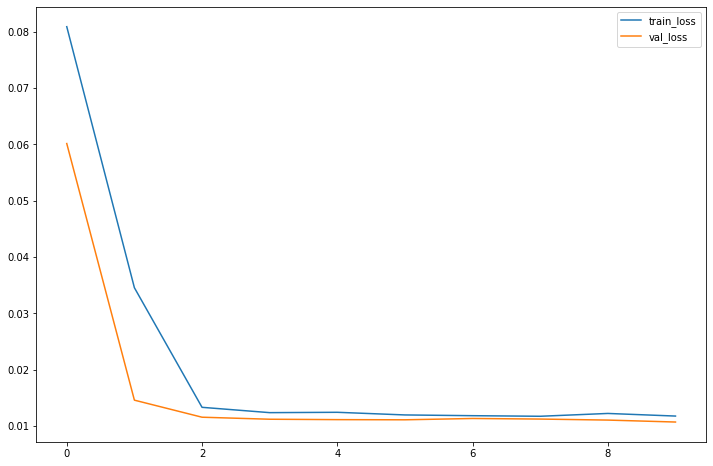

In [ ]:
fig,ax = plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.set_xlabel = 'Time (Epochs)'
ax.set_ylabel = 'Loss'
ax.legend();

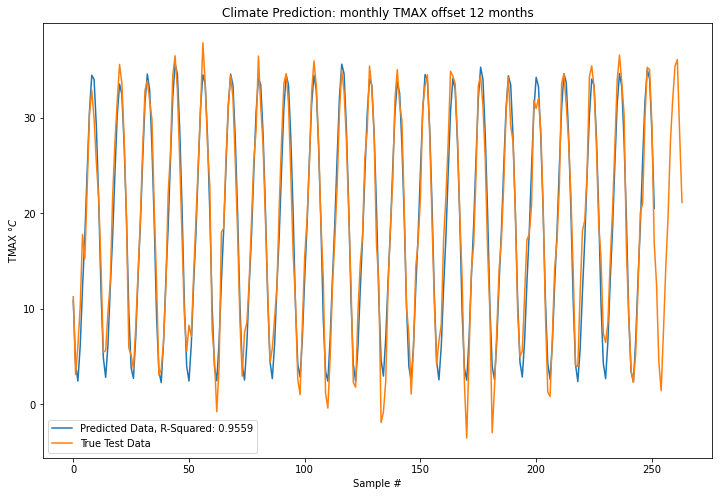

In [ ]:
#test predictions
test_predict=modelAlpha.predict(test_data)

#For TMAX
#R-squared with true values
Rsqr = np.corrcoef(test_label[:-offset,0], test_predict[offset:,0])[0,1]**2

#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,0]*adj['TMAX'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,0]*adj['TMAX'],label="True Test Data")
ax.set_title("Climate Prediction: monthly TMAX offset 12 months")
ax.set_xlabel("Sample #")
ax.set_ylabel("TMAX $\degree C$")
ax.legend();

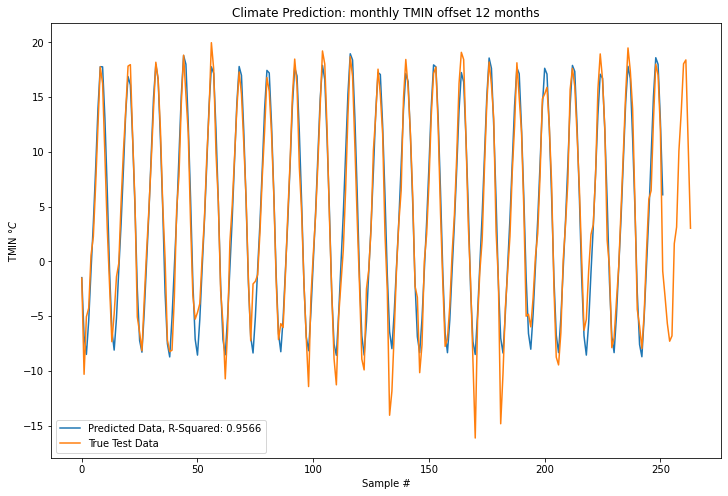

In [ ]:
#For TMIN
#R-squared with true values
Rsqr = np.corrcoef(test_label[:-offset,1], test_predict[offset:,1])[0,1]**2

#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,1]*adj['TMIN'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,1]*adj['TMIN'],label="True Test Data")
ax.set_title("Climate Prediction: monthly TMIN offset 12 months")
ax.set_xlabel("Sample #")
ax.set_ylabel("TMIN $\degree C$")
ax.legend();

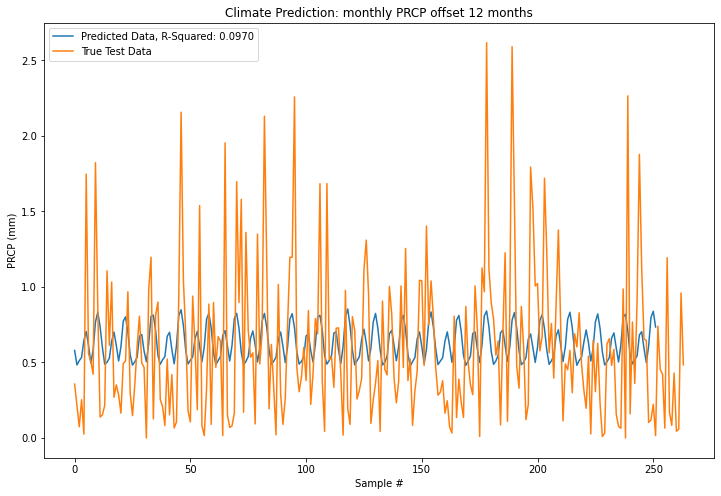

In [ ]:
#For PRCP
#R-squared with true values
Rsqr = np.corrcoef(test_label[:-offset,2], test_predict[offset:,2])[0,1]**2

#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,2]*adj['PRCP'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,2]*adj['PRCP'],label="True Test Data")
ax.set_title("Climate Prediction: monthly PRCP offset 12 months")
ax.set_xlabel("Sample #")
ax.set_ylabel("PRCP (mm)")
ax.legend();

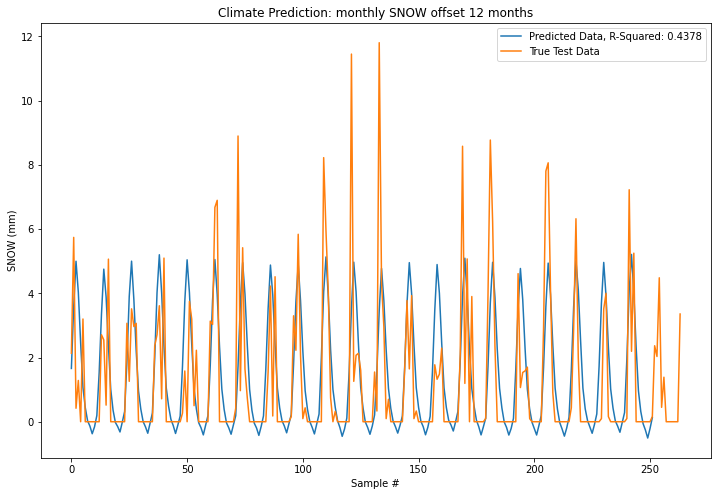

In [ ]:
#For SNOW
#R-squared with true values
Rsqr = np.corrcoef(test_label[:-offset,3], test_predict[offset:,3])[0,1]**2

#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,3]*adj['SNOW'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,3]*adj['SNOW'],label="True Test Data")
ax.set_title("Climate Prediction: monthly SNOW offset 12 months")
ax.set_xlabel("Sample #")
ax.set_ylabel("SNOW (mm)")
ax.legend();

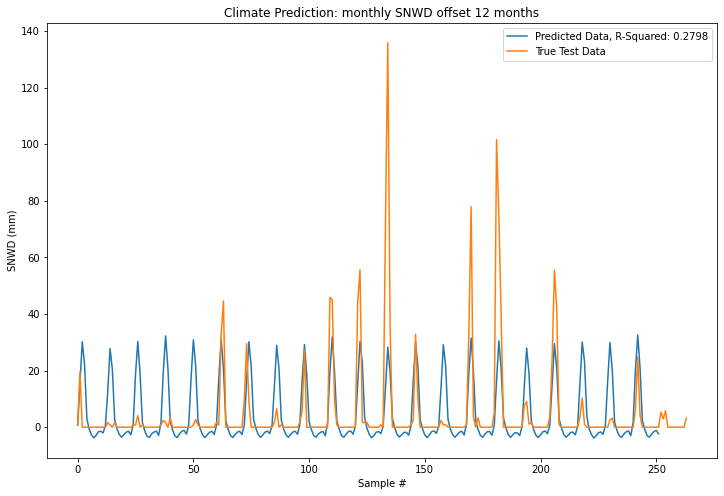

In [ ]:
#For SNWD
#R-squared with true values
Rsqr = np.corrcoef(test_label[:-offset,4], test_predict[offset:,4])[0,1]**2

#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,4]*adj['SNWD'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,4]*adj['SNWD'],label="True Test Data")
ax.set_title("Climate Prediction: monthly SNWD offset 12 months")
ax.set_xlabel("Sample #")
ax.set_ylabel("SNWD (mm)")
ax.legend();

## TASK VI. continued
The Model matches the periodicity in the data for all except for PRCP, which seems to be highly variable and hard to model. For the others, the amplitudes of the extreme values are often incorrect as these may vary substantially year by year. TMAX is the closest element modelled with an R-squared of 95%.

## TASK VII. Conduct weather prediction experiments.
For the weather prediction, daily data with an offset of zero needed to be used. It was decided to integrate data from the Arkansas station into the model. First this needed to be investigated. Its dataframe was labelled dlyAK to distinguish it; this suffix was continued for other dataframes and elements names used.

In [ ]:
filename = 'USW00026411.dly'
dlyAK = read_ghcn_data_file(filename=filename)

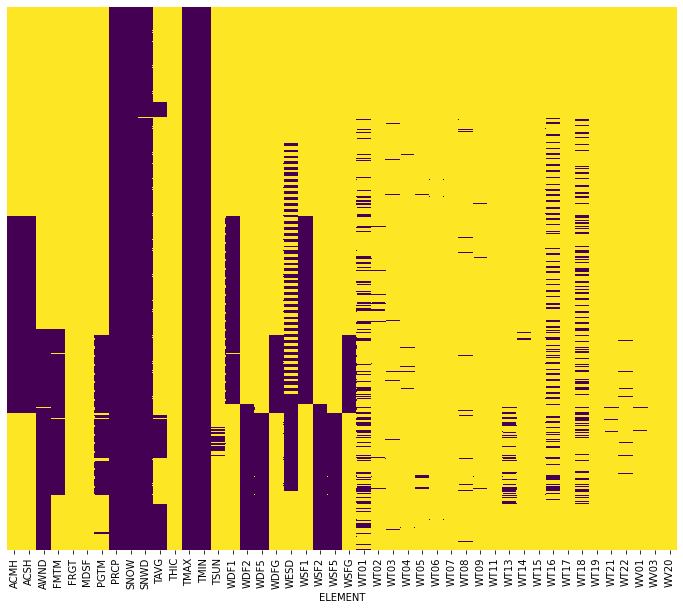

In [ ]:
#Heatmap for VALUES
sns.heatmap(data=dlyAK['VALUE'].isnull(), yticklabels=False, cbar = False, cmap ='viridis');

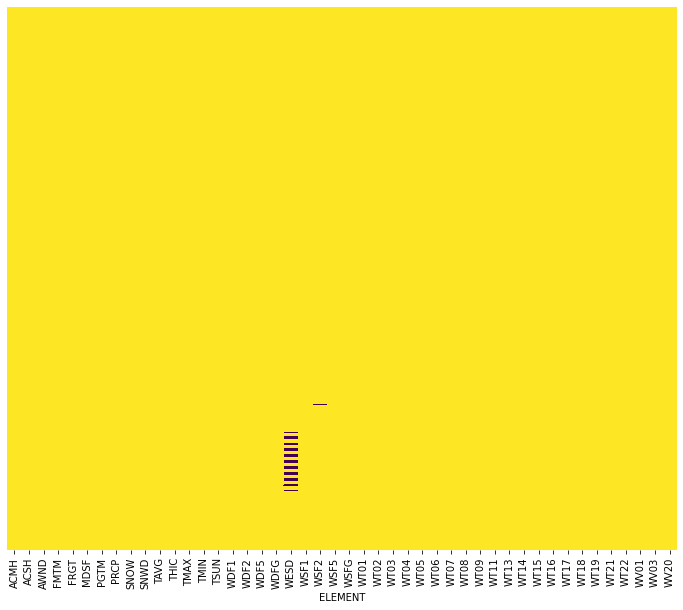

In [ ]:
#Heatmap for QFLAG
sns.heatmap(data=dlyAK['QFLAG'].isnull(), yticklabels=False, cbar = False, cmap ='viridis');

## Task VII. continued
The Arkansas station shows good coverage for the 5 main elements, but also the same five extra wind related elements, albeit with later starting dates. It does not look like there are any quality issues, but there may be some more significant gaps in two of them. It was decided to investigate whether these should be included into the model. 

In [ ]:
#the following code loops through the 5 main elements and 5 wind elements to determine their start dates
print('For AK station, start dates are:')
for i in ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5','WSF2','WSF5']:
    
    if i in dlyAK['VALUE']: #where .dly file contains the relevant data columns
      #start date of each element i
      print(i, dlyAK[dlyAK['VALUE'][i].notnull() == True].index.min())      

For AK station, start dates are:
TMAX 1929-12-01 00:00:00
TMIN 1929-12-01 00:00:00
PRCP 1929-12-01 00:00:00
SNOW 1929-12-01 00:00:00
SNWD 1929-12-01 00:00:00
AWND 1984-01-01 00:00:00
WDF2 1996-07-01 00:00:00
WDF5 1997-12-01 00:00:00
WSF2 1996-07-01 00:00:00
WSF5 1997-12-01 00:00:00


## Task VII. continued
Now the same was checked for the Colorado station.

In [ ]:
filename = 'USW00023066.dly'
dly = read_ghcn_data_file(filename=filename)
print('For CO station, start dates are:')
for i in ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5','WSF2','WSF5']:
    
    if i in dly['VALUE']: #where .dly file contains the relevant data columns
      #start date of each element i
      print(i, dly[dly['VALUE'][i].notnull() == True].index.min())   

For CO station, start dates are:
TMAX 1900-01-01 00:00:00
TMIN 1900-01-01 00:00:00
PRCP 1900-01-01 00:00:00
SNOW 1900-01-01 00:00:00
SNWD 1900-01-01 00:00:00
AWND 1984-01-01 00:00:00
WDF2 1996-04-01 00:00:00
WDF5 1996-04-01 00:00:00
WSF2 1996-04-01 00:00:00
WSF5 1996-04-01 00:00:00


## Task VII. continued
The start date for the data should be 1997-12-01. New dataframe was created for Colorado stations from this date and including the 10 elements.

In [ ]:
filename = 'USW00023066.dly'
dly = read_ghcn_data_file(filename=filename)
#drop MFLAG and QFLAG column
dly.drop(('MFLAG'), axis = 1, inplace = True)
dly.drop(('QFLAG'), axis = 1, inplace = True)

#drop VAR_TYPE column hierarchy as no longer needed 
dly_10 = dly.droplevel('VAR_TYPE',axis= 1)

#select the desired 10 columns
dly_10 = dly_10[['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5','WSF2','WSF5']]
dly_10 = dly_10[dly_10.index >= '1997-12-01 00:00:00']

dly_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8385 entries, 1997-12-01 to 2020-11-14
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8385 non-null   float64
 1   TMIN    8385 non-null   float64
 2   PRCP    8385 non-null   float64
 3   SNOW    8384 non-null   float64
 4   SNWD    8383 non-null   float64
 5   AWND    8379 non-null   float64
 6   WDF2    8383 non-null   float64
 7   WDF5    8366 non-null   float64
 8   WSF2    8383 non-null   float64
 9   WSF5    8366 non-null   float64
dtypes: float64(10)
memory usage: 720.6 KB


## Task VII. continued
There were only a tiny number of null values, so again forward fill was used.

In [ ]:
dly_10.fillna(method='ffill', inplace = True)
dly_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8385 entries, 1997-12-01 to 2020-11-14
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8385 non-null   float64
 1   TMIN    8385 non-null   float64
 2   PRCP    8385 non-null   float64
 3   SNOW    8385 non-null   float64
 4   SNWD    8385 non-null   float64
 5   AWND    8385 non-null   float64
 6   WDF2    8385 non-null   float64
 7   WDF5    8385 non-null   float64
 8   WSF2    8385 non-null   float64
 9   WSF5    8385 non-null   float64
dtypes: float64(10)
memory usage: 720.6 KB


## Task VII. continued
Procedure was repeated for AK station dataframe.

In [ ]:
filename = 'USW00026411.dly'
dlyAK = read_ghcn_data_file(filename=filename)

#drop MFLAG and QFLAG column
dlyAK.drop(('MFLAG'), axis = 1, inplace = True)
dlyAK.drop(('QFLAG'), axis = 1, inplace = True)

#drop VAR_TYPE column hierarchy as no longer needed 
dlyAK_10 = dlyAK.droplevel('VAR_TYPE',axis= 1)

#select the desired 10 columns
dlyAK_10 = dlyAK_10[['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5','WSF2','WSF5']]
dlyAK_10 = dlyAK_10[dlyAK_10.index >= '1997-12-01 00:00:00']

dlyAK_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8385 entries, 1997-12-01 to 2020-11-14
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8385 non-null   float64
 1   TMIN    8385 non-null   float64
 2   PRCP    8385 non-null   float64
 3   SNOW    8385 non-null   float64
 4   SNWD    8385 non-null   float64
 5   AWND    8378 non-null   float64
 6   WDF2    8369 non-null   float64
 7   WDF5    8318 non-null   float64
 8   WSF2    8369 non-null   float64
 9   WSF5    8319 non-null   float64
dtypes: float64(10)
memory usage: 720.6 KB


## Task VII. continued
The were slightly more null values for the wind elements (maximum was 67/8385 for WDF5 or 0.8% of data), so it was decided to run a heatmap to see if this omissions were bunched or spread out.

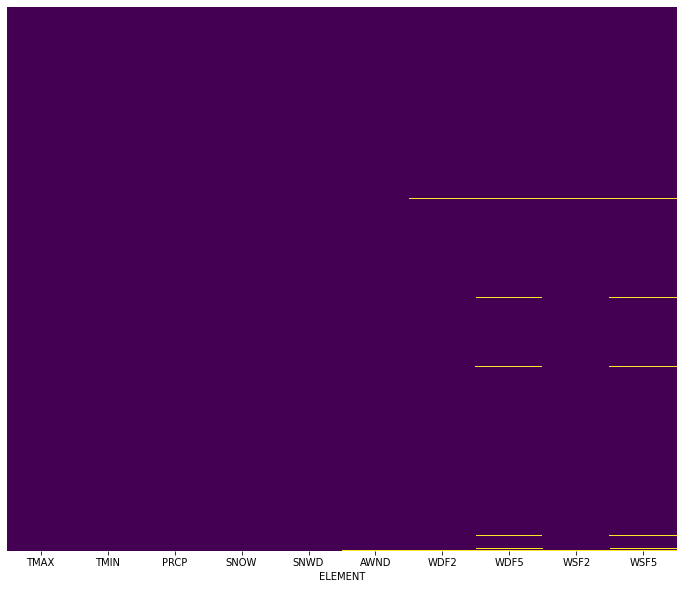

In [ ]:
import seaborn as sns
sns.heatmap(data=dlyAK_10.isnull(), yticklabels=False, cbar = False, cmap ='viridis');

## Task VII. continued
The element with the most gaps has the gaps spread out over five or more intervals. It was therefore considered appropriate to use the forward fill method to close the gaps.

In [ ]:
dlyAK_10.fillna(method='ffill', inplace = True)
dlyAK_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8385 entries, 1997-12-01 to 2020-11-14
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8385 non-null   float64
 1   TMIN    8385 non-null   float64
 2   PRCP    8385 non-null   float64
 3   SNOW    8385 non-null   float64
 4   SNWD    8385 non-null   float64
 5   AWND    8385 non-null   float64
 6   WDF2    8385 non-null   float64
 7   WDF5    8385 non-null   float64
 8   WSF2    8385 non-null   float64
 9   WSF5    8385 non-null   float64
dtypes: float64(10)
memory usage: 720.6 KB


## Task VII. continued
Gaps were filled in the AK dataframe. It was decided to check on the range of the values for both dataframes. First for Colorado.

In [ ]:
dly_10.describe()

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5
count,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000
mean,19.205176,4.534097,0.609600,1.221705,4.640310,33.073465,192.474061,201.688134,89.615504,109.462254
std,11.886553,9.770772,2.132795,8.409195,19.436384,13.656783,96.644318,95.692428,54.845242,44.092750
min,-11.700000,-26.700000,0.000000,0.000000,0.000000,3.000000,5.000000,5.000000,22.000000,27.000000
25%,8.900000,-2.800000,0.000000,0.000000,0.000000,23.000000,120.000000,120.000000,67.000000,76.000000
50%,19.400000,4.400000,0.000000,0.000000,0.000000,31.000000,160.000000,190.000000,80.000000,98.000000
75%,30.000000,13.300000,0.000000,0.000000,0.000000,41.000000,300.000000,300.000000,107.000000,134.000000
max,41.100000,25.600000,30.700000,183.000000,203.000000,105.000000,360.000000,360.000000,4095.000000,326.000000


## Task VII. continued
The wind speeds (WSF2 and WSF5) are measured in tenths of metres per second. The maximum of WSF2 seems too high and needs to be investigated. This was done by counting how many values are greater than 50m/s or 500 tenths of metres per second.

In [ ]:
count = dly_10['WSF2'][dly_10['WSF2']>500].count()
print('How many WSF2 values > 50 m/s:', count)

How many WSF2 values > 50 m/s: 1


In [ ]:
#to locate it
dly_10[dly_10['WSF2']>500]

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5
2003-05-13,25.0,7.8,0.0,0.0,0.0,18.0,90.0,240.0,4095.0,94.0


In [ ]:
#to find values of WSF2 2 days either side
dly_10[dly_10.index>= '2003-05-11'].head()

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5
2003-05-11,20.0,3.3,0.0,0.0,0.0,41.0,100.0,330.0,76.0,103.0
2003-05-12,26.1,6.1,0.0,0.0,0.0,42.0,310.0,300.0,103.0,130.0
2003-05-13,25.0,7.8,0.0,0.0,0.0,18.0,90.0,240.0,4095.0,94.0
2003-05-14,27.8,7.8,0.0,0.0,0.0,34.0,270.0,250.0,94.0,107.0
2003-05-15,19.4,10.6,8.1,0.0,0.0,41.0,280.0,120.0,98.0,116.0


In [ ]:
#average the values two days either side
av = np.mean([76,103,94,98])

#replace 4095.0 with av
#NB is safe to do so as 4095.0 is outside ranges of all other elements
dly_10.replace(4095.0, av, inplace = True)
dly_10.describe()

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5
count,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000
mean,19.205176,4.534097,0.609600,1.221705,4.640310,33.073465,192.474061,201.688134,89.138193,109.462254
std,11.886553,9.770772,2.132795,8.409195,19.436384,13.656783,96.644318,95.692428,33.079232,44.092750
min,-11.700000,-26.700000,0.000000,0.000000,0.000000,3.000000,5.000000,5.000000,22.000000,27.000000
25%,8.900000,-2.800000,0.000000,0.000000,0.000000,23.000000,120.000000,120.000000,67.000000,76.000000
50%,19.400000,4.400000,0.000000,0.000000,0.000000,31.000000,160.000000,190.000000,80.000000,98.000000
75%,30.000000,13.300000,0.000000,0.000000,0.000000,41.000000,300.000000,300.000000,107.000000,134.000000
max,41.100000,25.600000,30.700000,183.000000,203.000000,105.000000,360.000000,360.000000,241.000000,326.000000


## Task VII. continued
This showed that the anomalous datapoint had been successfully replaced. Now the AK station dataframe was investigated.

In [ ]:
dlyAK_10.describe()

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5
count,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000,8385.000000
mean,3.587156,-7.430221,0.848169,4.011568,163.674776,16.447704,155.014908,160.474299,51.927967,64.985092
std,15.931067,15.732762,2.735986,16.143101,203.174567,12.205077,116.029773,112.784005,23.353639,31.659114
min,-42.800000,-48.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.800000,-20.600000,0.000000,0.000000,0.000000,7.000000,40.000000,50.000000,36.000000,40.000000
50%,5.000000,-4.400000,0.000000,0.000000,25.000000,15.000000,140.000000,170.000000,45.000000,63.000000
75%,17.800000,6.700000,0.300000,0.000000,305.000000,23.000000,260.000000,260.000000,67.000000,89.000000
max,33.300000,21.100000,57.700000,302.000000,860.000000,100.000000,360.000000,360.000000,183.000000,264.000000


## Task VII. continued
This dataframe seemed fine. To concatenate these two dataframes into one, it was necessary to rename elements (columns) and this was done in the AK station dataframe using "ak" suffix. Then, they could be concatenated.

In [ ]:
#rename so we can concatenate dly_10 and dlyAK_10
dlyAK_10.rename(columns={"TMAX": "TMAXak", "TMIN": "TMINak",
                        "PRCP": "PRCPak", "SNOW": "SNOWak",
                        "SNWD": "SNWDak", "AWND": "AWNDak",
                        "WDF2": "WDF2ak", "WDF5": "WDF5ak",
                        "WSF2": "WSF2ak", "WSF5": "WSF5ak"}, inplace=True)
dlyAK_10.head(1)

ELEMENT,TMAXak,TMINak,PRCPak,SNOWak,SNWDak,AWNDak,WDF2ak,WDF5ak,WSF2ak,WSF5ak
1997-12-01,-12.8,-25.6,1.5,41.0,381.0,4.0,200.0,230.0,27.0,31.0


In [ ]:
dly_10 = pd.concat([dly_10, dlyAK_10], axis =1)
dly_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8385 entries, 1997-12-01 to 2020-11-14
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8385 non-null   float64
 1   TMIN    8385 non-null   float64
 2   PRCP    8385 non-null   float64
 3   SNOW    8385 non-null   float64
 4   SNWD    8385 non-null   float64
 5   AWND    8385 non-null   float64
 6   WDF2    8385 non-null   float64
 7   WDF5    8385 non-null   float64
 8   WSF2    8385 non-null   float64
 9   WSF5    8385 non-null   float64
 10  TMAXak  8385 non-null   float64
 11  TMINak  8385 non-null   float64
 12  PRCPak  8385 non-null   float64
 13  SNOWak  8385 non-null   float64
 14  SNWDak  8385 non-null   float64
 15  AWNDak  8385 non-null   float64
 16  WDF2ak  8385 non-null   float64
 17  WDF5ak  8385 non-null   float64
 18  WSF2ak  8385 non-null   float64
 19  WSF5ak  8385 non-null   float64
dtypes: float64(20)
memory usage: 1.3 MB


# Task VII. continued
The elements needed to be normalised before training. 

In [ ]:
dly_10, adj = normalise(dly_10)

## Task VII. continued
It was required to predict the next day's data so the offset was zero. It was decided to use 365 days for $n_{ts}$. 

In [ ]:
offset=0#predict one day forward
n_ts=365 #1 years of daily data for training
nn_df=make_offset_dataframe(dly_10,n_ts,offset)
nn_df.dropna(axis=0, inplace=True)#lose rows with NaN
#check
nn_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8020 entries, 1998-12-01 to 2020-11-14
Columns: 7320 entries, (0, 'TMAX') to ('label', 'WSF5ak')
dtypes: float64(7320)
memory usage: 448.0 MB


## Task VII. continued
This is a very large dataframe with over 19 million values contained. Now the data needed to be split into training, validation and test datasets as before. The same model was used, but adapted for 20 features and then trained as before.

In [ ]:
train_data, val_data, test_data, train_label, val_label, test_label = dataset_split(nn_df)

train_data (4812, 365, 20)
val_data (1604, 365, 20)
test_data (1604, 365, 20)


In [ ]:
#adapted from Week6_pandas.ipynb
modelAlpha=keras.models.Sequential()
#input shape adapted
#again have calculated no of elements from shape of nn_df and n_ts
#to allow for general use
modelAlpha.add(keras.layers.LSTM(64,input_shape=(n_ts,int(nn_df.shape[1]/ (n_ts + 1))),return_sequences=True))
modelAlpha.add(keras.layers.LSTM(32,activation='relu'))
modelAlpha.add(keras.layers.Dense(32,activation='relu'))

#output the 5 elements
modelAlpha.add(keras.layers.Dense(int(nn_df.shape[1]/ (n_ts + 1)),activation="linear"))
modelAlpha.compile(loss='mean_squared_error',optimizer='adam')
modelAlpha.summary()



history=modelAlpha.fit(train_data,train_label,epochs=10,batch_size=10,verbose=1,validation_data=(val_data,val_label))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 365, 64)           21760     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 20)                660       
                                                                 
Total params: 35,892
Trainable params: 35,892
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
482/482 [==============================] - 141s 287ms/step - loss: 0.0373 - val_loss: 0.0281
Epoch 2/10
482/482 [==============================] - 140s 290ms/step - loss: 

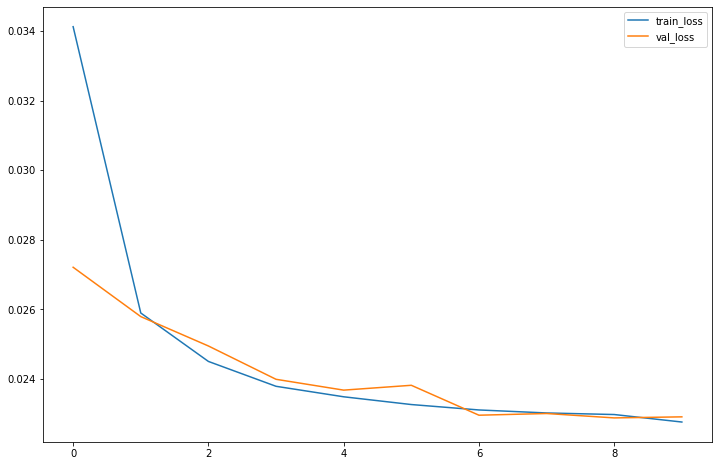

In [ ]:
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend();

## Task VII. continued
Training completed and the loss function converged quickly. It was decided to just consider the main elements for the Colorado station for analysis, rather than all 20 elements used.

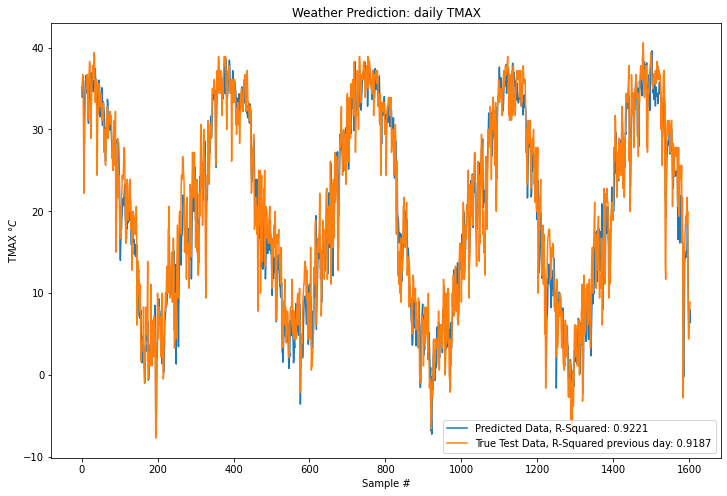

In [ ]:
#test predictions
test_predict=model.predict(test_data)

#For TMAX
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,0], test_predict[:,0])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,0], test_label[:-1,0])[0,1]**2

#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,0]*adj['TMAX'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,0]*adj['TMAX'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily TMAX")
ax.set_xlabel("Sample #")
ax.set_ylabel("TMAX $\degree C$")
ax.legend();

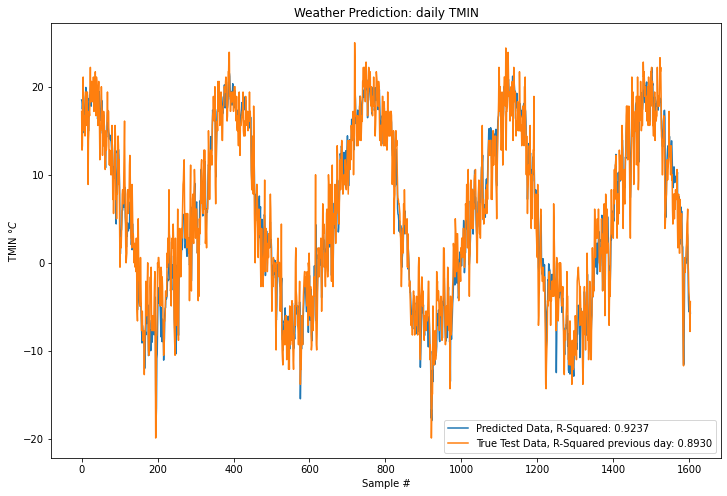

In [ ]:
#For TMIN
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,1], test_predict[:,1])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,1], test_label[:-1,1])[0,1]**2
#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,1]*adj['TMIN'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,1]*adj['TMIN'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily TMIN")
ax.set_xlabel("Sample #")
ax.set_ylabel("TMIN $\degree C$")
ax.legend();

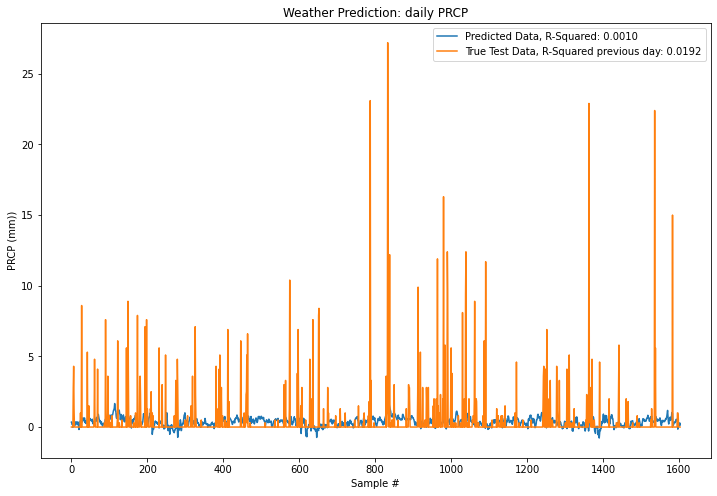

In [ ]:
#For PRCP
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,2], test_predict[:,2])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,2], test_label[:-1,2])[0,1]**2
#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,2]*adj['PRCP'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,2]*adj['PRCP'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily PRCP")
ax.set_xlabel("Sample #")
ax.set_ylabel("PRCP (mm))")
ax.legend();

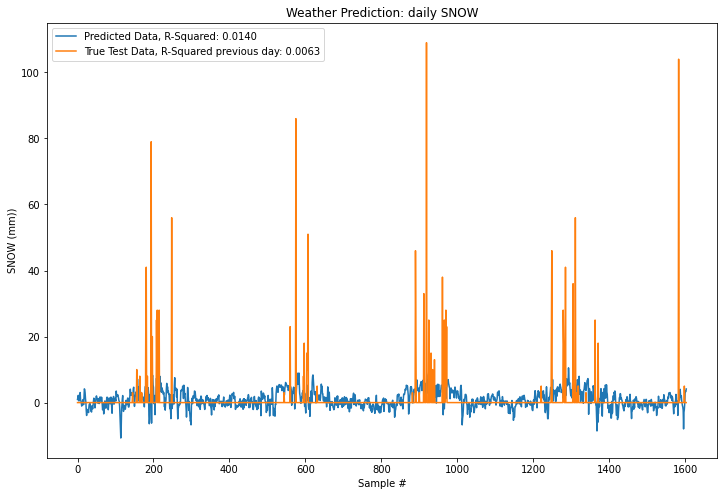

In [ ]:
#For SNOW
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,3], test_predict[:,3])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,3], test_label[:-1,3])[0,1]**2
#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,3]*adj['SNOW'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,3]*adj['SNOW'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily SNOW")
ax.set_xlabel("Sample #")
ax.set_ylabel("SNOW (mm))")
ax.legend();


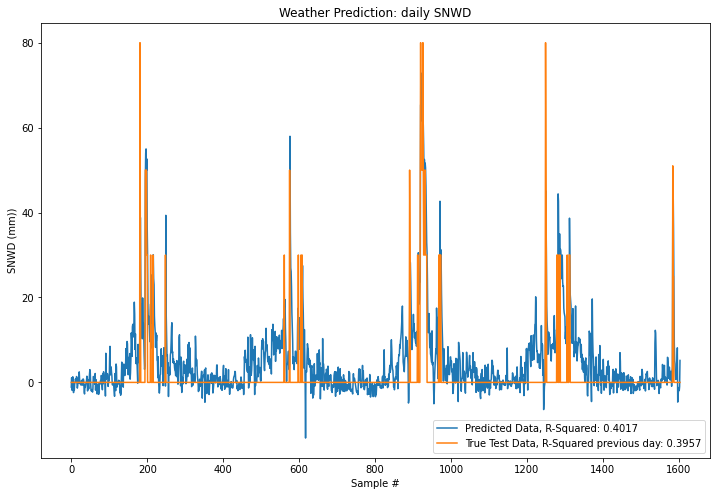

In [ ]:
#For SNWD
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,4], test_predict[:,4])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,4], test_label[:-1,4])[0,1]**2
#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,4]*adj['SNWD'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,4]*adj['SNWD'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily SNWD")
ax.set_xlabel("Sample #")
ax.set_ylabel("SNWD (mm))")
ax.legend();


## Task VII. continued
The conclusion is that the model has improved the prediction of tomorrow's temperature (as measured by TMAX and TMIN) compared to just assuming it will be the same as today's. The predictive models for the other elements do not provide a good fit as the occurrence of precipitation, snow and snow depths are just too variable on a day to day basis.

## Task VIII. Decide on an extension project
It was decided to see if predictions of tomorrow's temperature (TMAX and TMIN) in Colorado could be improved by including data from nearby stations from neigbouring states. Reviewing the 26 filtered stations- i.e. those with the best data, three were selected (no others were in Colorado): Oklahoma City, OK; Albuquerque, NM and North Platte, NE. There was another Nebraska station, Norfolk, but this was further away. 
<p>It was decided to also vary some of the parameters to get the best prediction. NB in several cases, the models have been re-trained using the existing code cells after changing a parameter. This was done for the sake of brevity, but the key results are recorded in text cells for use in report.  
<p>First, these new datasets needed to be investigated in turn.


In [ ]:
filename = 'USW00013967.dly'
dlyOK = read_ghcn_data_file(filename=filename)

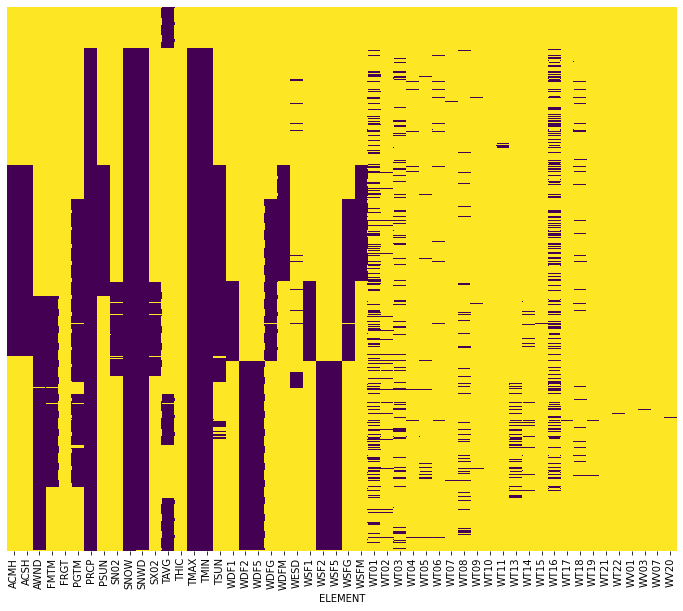

In [ ]:
#Heatmap for VALUES
sns.heatmap(data=dlyOK['VALUE'].isnull(), yticklabels=False, cbar = False, cmap ='viridis');

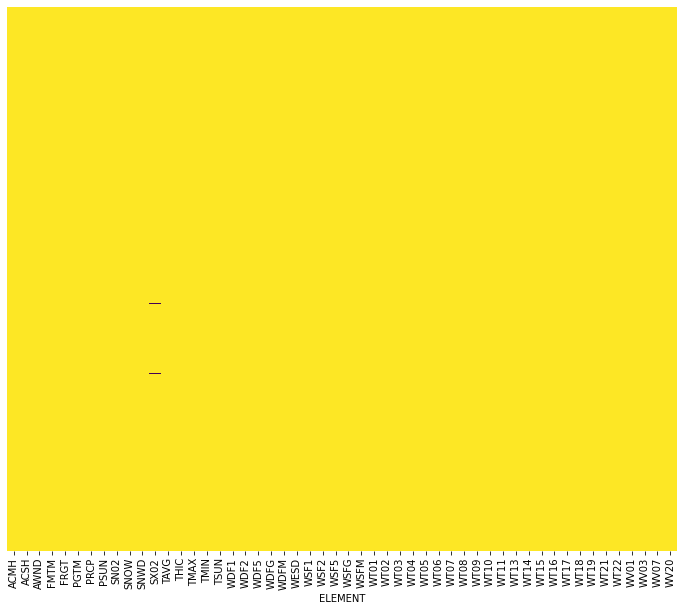

In [ ]:
#Heatmap for QFLAG
sns.heatmap(data=dlyOK['QFLAG'].isnull(), yticklabels=False, cbar = False, cmap ='viridis');

## Task VIII. continued
Good coverage of the 10 elements previously used in Task VII, with no quality issues shown. Now for Albuquerque, NM:

In [ ]:
filename = 'USW00023050.dly'
dlyNM = read_ghcn_data_file(filename=filename)

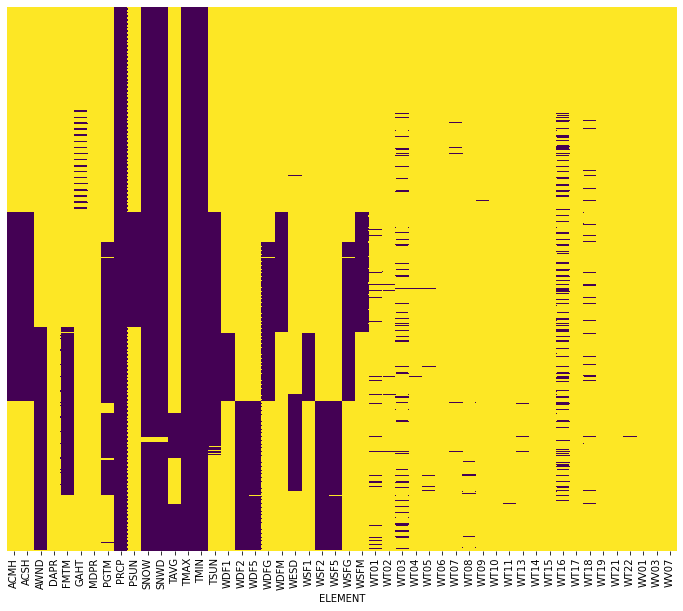

In [ ]:
#Heatmap for VALUES
sns.heatmap(data=dlyNM['VALUE'].isnull(), yticklabels=False, cbar = False, cmap ='viridis');

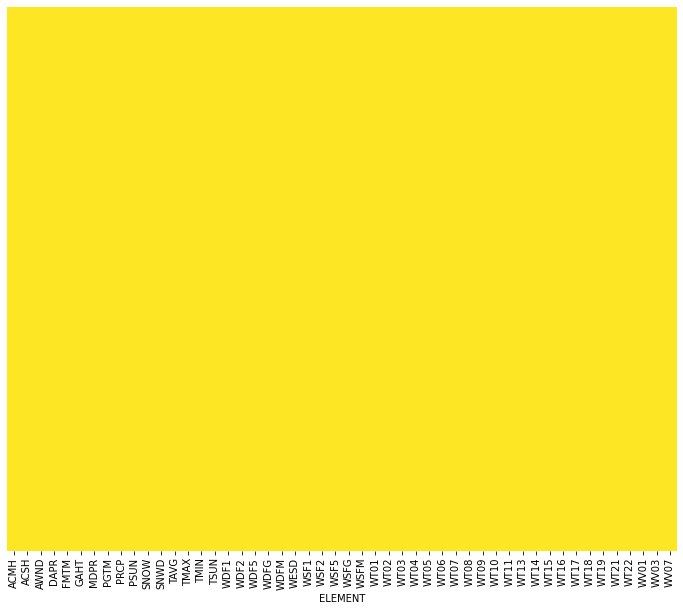

In [ ]:
#Heatmap for QFLAG
sns.heatmap(data=dlyNM['QFLAG'].isnull(), yticklabels=False, cbar = False, cmap ='viridis');

## Task VIII. continued
Apart from gap in SNOW and SNWD, good coverage of the 10 elements previously used in Task VII, with no quality issues shown. Now for North Platte, NE:

In [ ]:
filename = 'USW00024023.dly'
dlyNE = read_ghcn_data_file(filename=filename)

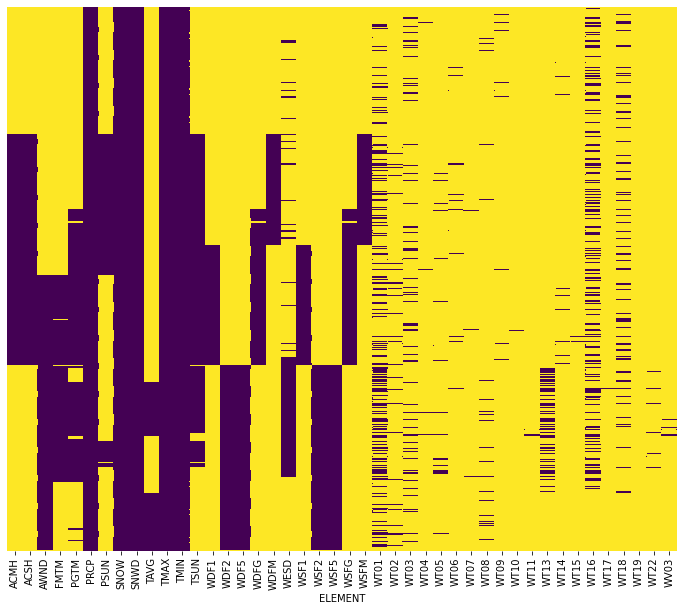

In [ ]:
#Heatmap for VALUES
sns.heatmap(data=dlyNE['VALUE'].isnull(), yticklabels=False, cbar = False, cmap ='viridis');

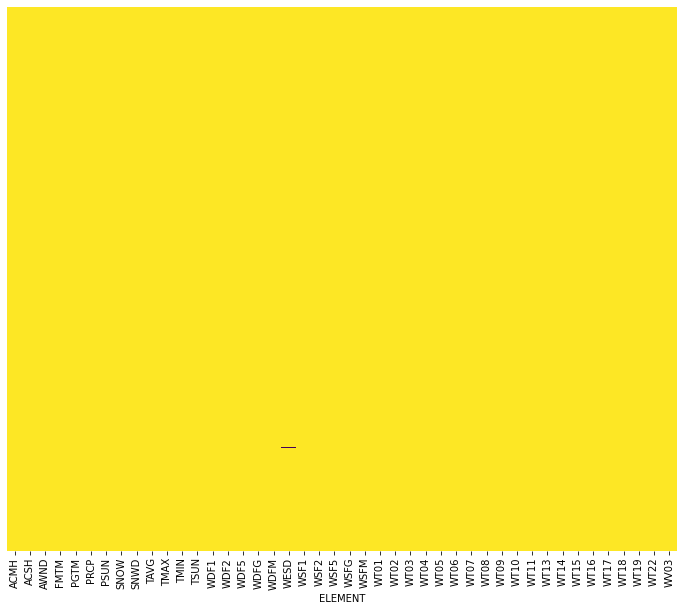

In [ ]:
#Heatmap for QFLAG
sns.heatmap(data=dlyNE['QFLAG'].isnull(), yticklabels=False, cbar = False, cmap ='viridis');

# Task VIII. continued
Good coverage of the 10 elements and no quality issues visible. Now, the start dates of each of the dataframe for the 5 extra elements was determined.

In [ ]:
#the following code loops through the 5 wind elements to determine their start dates
cols = ['AWND', 'WDF2', 'WDF5','WSF2','WSF5']
print('OK station')
for i in cols:
    
    if i in dlyOK['VALUE']: #where .dly file contains the relevant data columns
      #start date of each element i
      print(i, dlyOK[dlyOK['VALUE'][i].notnull() == True].index.min()) 

print('\nNM station')
for i in cols:
    
    if i in dlyNM['VALUE']: #where .dly file contains the relevant data columns
      #start date of each element i
      print(i, dlyNM[dlyNM['VALUE'][i].notnull() == True].index.min())

print('\nNE station')
for i in cols:
    
    if i in dlyNE['VALUE']: #where .dly file contains the relevant data columns
      #start date of each element i
      print(i, dlyNE[dlyNE['VALUE'][i].notnull() == True].index.min())


OK station
AWND 1984-01-01 00:00:00
WDF2 1993-06-01 00:00:00
WDF5 1993-06-01 00:00:00
WSF2 1993-06-01 00:00:00
WSF5 1993-06-01 00:00:00

NM station
AWND 1984-01-01 00:00:00
WDF2 1996-03-01 00:00:00
WDF5 1996-03-01 00:00:00
WSF2 1996-03-01 00:00:00
WSF5 1996-03-01 00:00:00

NE station
AWND 1984-01-01 00:00:00
WDF2 1996-02-01 00:00:00
WDF5 1996-02-01 00:00:00
WSF2 1996-02-01 00:00:00
WSF5 1996-02-01 00:00:00


## Task VIII. continued
Latest start date was from Colorado station 1996-04-01. Now, the datasets could be prepared and concatenated.

In [ ]:
#For Colorado
filename = 'USW00023066.dly'
dly = read_ghcn_data_file(filename=filename)
#drop MFLAG and QFLAG column
dly.drop(('MFLAG'), axis = 1, inplace = True)
dly.drop(('QFLAG'), axis = 1, inplace = True)

#drop VAR_TYPE column hierarchy as no longer needed 
dly_10 = dly.droplevel('VAR_TYPE',axis= 1)

#select the desired 10 columns
dly_10 = dly_10[['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5','WSF2','WSF5']]
dly_10 = dly_10[dly_10.index >= '1996-04-01 00:00:00']

dly_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8994 entries, 1996-04-01 to 2020-11-14
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8994 non-null   float64
 1   TMIN    8994 non-null   float64
 2   PRCP    8994 non-null   float64
 3   SNOW    8993 non-null   float64
 4   SNWD    8992 non-null   float64
 5   AWND    8988 non-null   float64
 6   WDF2    8991 non-null   float64
 7   WDF5    8974 non-null   float64
 8   WSF2    8991 non-null   float64
 9   WSF5    8974 non-null   float64
dtypes: float64(10)
memory usage: 772.9 KB


In [ ]:
#fill forward and replace extreme value as before
dly_10.fillna(method='ffill', inplace = True)
av = np.mean([76,103,94,98])
#replace 4095.0 with av
#NB is safe to do so as 4095.0 is outside ranges of all other elements
dly_10.replace(4095.0, av, inplace = True)
dly_10.describe()
dly_10.describe()

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5
count,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000
mean,19.324194,4.649922,0.627374,1.210140,4.365577,33.157216,191.954080,201.101290,89.188654,109.286747
std,11.837798,9.713334,2.180278,8.323179,18.854957,13.591177,96.692829,95.694897,32.979833,43.797287
min,-11.700000,-26.700000,0.000000,0.000000,0.000000,3.000000,5.000000,5.000000,22.000000,27.000000
25%,9.400000,-2.800000,0.000000,0.000000,0.000000,23.000000,120.000000,120.000000,67.000000,76.000000
50%,20.000000,4.400000,0.000000,0.000000,0.000000,31.000000,160.000000,190.000000,80.000000,98.000000
75%,30.000000,13.300000,0.000000,0.000000,0.000000,41.000000,300.000000,300.000000,107.000000,134.000000
max,41.100000,25.600000,33.300000,183.000000,203.000000,105.000000,360.000000,360.000000,255.000000,326.000000


In [ ]:
#For Oklahoma
filename = 'USW00013967.dly'
dlyOK = read_ghcn_data_file(filename=filename)
#drop MFLAG and QFLAG column
dlyOK.drop(('MFLAG'), axis = 1, inplace = True)
dlyOK.drop(('QFLAG'), axis = 1, inplace = True)

#drop VAR_TYPE column hierarchy as no longer needed 
dlyOK_10 = dlyOK.droplevel('VAR_TYPE',axis= 1)

#select the desired 10 columns
dlyOK_10 = dlyOK_10[['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5','WSF2','WSF5']]
dlyOK_10 = dlyOK_10[dlyOK_10.index >= '1996-04-01 00:00:00']

dlyOK_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8990 entries, 1996-04-01 to 2020-11-14
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8990 non-null   float64
 1   TMIN    8990 non-null   float64
 2   PRCP    8990 non-null   float64
 3   SNOW    8989 non-null   float64
 4   SNWD    8958 non-null   float64
 5   AWND    8981 non-null   float64
 6   WDF2    8986 non-null   float64
 7   WDF5    8977 non-null   float64
 8   WSF2    8986 non-null   float64
 9   WSF5    8977 non-null   float64
dtypes: float64(10)
memory usage: 772.6 KB


In [ ]:
#For New Mexico
filename = 'USW00023050.dly'
dlyNM = read_ghcn_data_file(filename=filename)
#drop MFLAG and QFLAG column
dlyNM.drop(('MFLAG'), axis = 1, inplace = True)
dlyNM.drop(('QFLAG'), axis = 1, inplace = True)

#drop VAR_TYPE column hierarchy as no longer needed 
dlyNM_10 = dlyNM.droplevel('VAR_TYPE',axis= 1)

#select the desired 10 columns
dlyNM_10 = dlyNM_10[['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5','WSF2','WSF5']]
dlyNM_10 = dlyNM_10[dlyNM_10.index >= '1996-04-01 00:00:00']

dlyNM_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8990 entries, 1996-04-01 to 2020-11-14
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8990 non-null   float64
 1   TMIN    8990 non-null   float64
 2   PRCP    8990 non-null   float64
 3   SNOW    8746 non-null   float64
 4   SNWD    8746 non-null   float64
 5   AWND    8987 non-null   float64
 6   WDF2    8988 non-null   float64
 7   WDF5    8980 non-null   float64
 8   WSF2    8988 non-null   float64
 9   WSF5    8980 non-null   float64
dtypes: float64(10)
memory usage: 772.6 KB


In [ ]:
#For Nebraska
filename = 'USW00024023.dly'
dlyNE = read_ghcn_data_file(filename=filename)
#drop MFLAG and QFLAG column
dlyNE.drop(('MFLAG'), axis = 1, inplace = True)
dlyNE.drop(('QFLAG'), axis = 1, inplace = True)

#drop VAR_TYPE column hierarchy as no longer needed 
dlyNE_10 = dlyNE.droplevel('VAR_TYPE',axis= 1)

#select the desired 10 columns
dlyNE_10 = dlyNE_10[['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5','WSF2','WSF5']]
dlyNE_10 = dlyNE_10[dlyNE_10.index >= '1996-04-01 00:00:00']

dlyNE_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8994 entries, 1996-04-01 to 2020-11-14
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8994 non-null   float64
 1   TMIN    8994 non-null   float64
 2   PRCP    8994 non-null   float64
 3   SNOW    8990 non-null   float64
 4   SNWD    8992 non-null   float64
 5   AWND    8986 non-null   float64
 6   WDF2    8993 non-null   float64
 7   WDF5    8989 non-null   float64
 8   WSF2    8993 non-null   float64
 9   WSF5    8989 non-null   float64
dtypes: float64(10)
memory usage: 772.9 KB


## Task VIII. continued
Strangely, Oklahoma and New Mexico stations had four less entries at 8990 versus 8994 for the other 2.

In [ ]:
print('Dates not in OK station data')
for i in dly_10.index:
  if i not in dlyOK_10.index:
    print(i)

print('\nDates not in NM station data')
for i in dly_10.index:
  if i not in dlyNM_10.index:
    print(i)

Dates not in OK station data
2020-10-28 00:00:00
2020-10-29 00:00:00
2020-10-30 00:00:00
2020-10-31 00:00:00

Dates not in NM station data
2020-10-28 00:00:00
2020-10-29 00:00:00
2020-10-30 00:00:00
2020-10-31 00:00:00


## Task VIII. continued.
These rows needed to be added so dataframes all matched.

In [ ]:
#adapted from https://www.pythonprogramming.in/how-to-add-row-to-dataframe-with-time-stamp-index-in-pandas.html

for i in ['2020-10-28 00:00:00', '2020-10-29 00:00:00', '2020-10-30 00:00:00', '2020-10-31 00:00:00']:
  line = pd.to_datetime(i, format="%Y-%m-%d %H:%M:%S")
  new_row = pd.DataFrame(columns=['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5','WSF2','WSF5'], index=[line])
  dlyOK_10 = pd.concat([dlyOK_10, pd.DataFrame(new_row)], ignore_index=False)
  dlyNM_10 = pd.concat([dlyNM_10, pd.DataFrame(new_row)], ignore_index=False)

In [ ]:
dlyOK_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8994 entries, 1996-04-01 to 2020-10-31
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8990 non-null   float64
 1   TMIN    8990 non-null   float64
 2   PRCP    8990 non-null   float64
 3   SNOW    8989 non-null   float64
 4   SNWD    8958 non-null   float64
 5   AWND    8981 non-null   float64
 6   WDF2    8986 non-null   float64
 7   WDF5    8977 non-null   float64
 8   WSF2    8986 non-null   float64
 9   WSF5    8977 non-null   float64
dtypes: float64(10)
memory usage: 772.9 KB


In [ ]:
dlyNM_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8994 entries, 1996-04-01 to 2020-10-31
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8990 non-null   float64
 1   TMIN    8990 non-null   float64
 2   PRCP    8990 non-null   float64
 3   SNOW    8746 non-null   float64
 4   SNWD    8746 non-null   float64
 5   AWND    8987 non-null   float64
 6   WDF2    8988 non-null   float64
 7   WDF5    8980 non-null   float64
 8   WSF2    8988 non-null   float64
 9   WSF5    8980 non-null   float64
dtypes: float64(10)
memory usage: 772.9 KB


## Task VIII. continued
Additions appeared successful and it was decided to continue preparation of datasets in order OK, NM, NE.
<p>For OK station forward fill was used and describe() did not show any extreme values.

In [ ]:
#fill forward
dlyOK_10.fillna(method='ffill', inplace = True)
dlyOK_10.describe()

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5
count,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000
mean,22.657294,10.228664,2.536391,0.464198,0.898488,50.135980,190.966200,186.255281,99.442517,123.166555
std,10.168416,9.625214,9.202921,6.959854,10.363419,19.302236,101.476536,101.565133,32.252022,41.010551
min,-9.400000,-20.600000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,27.000000,0.000000
25%,15.600000,2.200000,0.000000,0.000000,0.000000,36.000000,140.000000,130.000000,76.000000,94.000000
50%,23.900000,11.100000,0.000000,0.000000,0.000000,47.000000,180.000000,180.000000,98.000000,116.000000
75%,31.100000,19.400000,0.000000,0.000000,0.000000,63.000000,290.000000,260.000000,116.000000,148.000000
max,45.000000,28.900000,193.500000,343.000000,356.000000,157.000000,360.000000,360.000000,443.000000,720.000000


In [ ]:
#rename so we can concatenate
dlyOK_10.rename(columns={"TMAX": "TMAXok", "TMIN": "TMINok",
                        "PRCP": "PRCPok", "SNOW": "SNOWok",
                        "SNWD": "SNWDok", "AWND": "AWNDok",
                        "WDF2": "WDF2ok", "WDF5": "WDF5ok",
                        "WSF2": "WSF2ok", "WSF5": "WSF5ok"}, inplace=True)
dlyOK_10.head(1)

ELEMENT,TMAXok,TMINok,PRCPok,SNOWok,SNWDok,AWNDok,WDF2ok,WDF5ok,WSF2ok,WSF5ok
1996-04-01,19.4,2.2,0.0,0.0,0.0,41.0,170.0,160.0,72.0,89.0


#Task VIII. continued
NM station had an issue with completeness of SNOW and SNWD to investigate.

In [ ]:
dlyNM_10[dlyNM_10['SNOW'].isnull() == True]

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5
2002-04-01,26.7,7.8,0.0,NaN,NaN,34.0,260.0,270.0,98.0,116.0
2002-04-02,26.7,6.1,0.0,NaN,NaN,67.0,90.0,90.0,192.0,215.0
2002-04-03,21.7,2.8,0.0,NaN,NaN,63.0,90.0,90.0,165.0,192.0
2002-04-04,24.4,7.2,0.0,NaN,NaN,41.0,220.0,220.0,170.0,192.0
2002-04-05,24.4,9.4,0.0,NaN,NaN,33.0,90.0,90.0,94.0,103.0
...,...,...,...,...,...,...,...,...,...,...
2002-11-30,13.3,-0.6,0.0,NaN,NaN,25.0,330.0,330.0,54.0,58.0
2020-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dlyNM_10[dlyNM_10.index == '2002-03-31']

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5
2002-03-31,22.8,6.7,0.0,0.0,0.0,27.0,180.0,210.0,54.0,67.0


# Task VIII. continued
It was assumed that SNOW and SNWD for these mostly spring, summer and autumn months are zero, so can use forward fill from 2002-03-31 when there was no snow or snwd.

In [ ]:
#fill forward
dlyNM_10.fillna(method='ffill', inplace = True)
dlyNM_10.describe()

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5
count,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000
mean,21.615944,7.894307,0.608495,0.516567,0.451634,36.384034,201.618857,204.827663,102.330220,127.025461
std,9.639201,8.680149,2.595973,5.920355,6.739745,16.556658,101.204263,99.890178,38.122336,48.083420
min,-12.800000,-21.700000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,27.000000,0.000000
25%,13.300000,0.600000,0.000000,0.000000,0.000000,25.000000,100.000000,110.000000,72.000000,89.000000
50%,22.800000,7.800000,0.000000,0.000000,0.000000,33.000000,200.000000,210.000000,98.000000,125.000000
75%,30.000000,16.100000,0.000000,0.000000,0.000000,44.000000,290.000000,290.000000,130.000000,161.000000
max,40.600000,25.600000,48.800000,287.000000,254.000000,139.000000,360.000000,770.000000,286.000000,398.000000


In [ ]:
#rename so we can concatenate
dlyNM_10.rename(columns={"TMAX": "TMAXnm", "TMIN": "TMINnm",
                        "PRCP": "PRCPnm", "SNOW": "SNOWnm",
                        "SNWD": "SNWDnm", "AWND": "AWNDnm",
                        "WDF2": "WDF2nm", "WDF5": "WDF5nm",
                        "WSF2": "WSF2nm", "WSF5": "WSF5nm"}, inplace=True)
dlyNM_10.head(1)

ELEMENT,TMAXnm,TMINnm,PRCPnm,SNOWnm,SNWDnm,AWNDnm,WDF2nm,WDF5nm,WSF2nm,WSF5nm
1996-04-01,23.9,5.0,0.0,0.0,0.0,47.0,180.0,200.0,98.0,125.0


In [ ]:
#fill forward
dlyNE_10.fillna(method='ffill', inplace = True)
dlyNE_10.describe()

ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5
count,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000
mean,17.919024,1.904937,1.481877,2.040138,6.231488,39.323660,196.256171,196.021792,95.631977,123.001001
std,11.710348,10.902464,5.307846,13.370988,25.444174,17.131418,110.792241,110.498934,33.390815,43.796050
min,-16.700000,-31.600000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,27.000000,31.000000
25%,9.400000,-6.700000,0.000000,0.000000,0.000000,27.000000,110.000000,110.000000,72.000000,94.000000
50%,18.900000,1.100000,0.000000,0.000000,0.000000,36.000000,180.000000,180.000000,89.000000,116.000000
75%,27.800000,11.700000,0.000000,0.000000,0.000000,47.000000,300.000000,300.000000,112.000000,148.000000
max,42.200000,24.400000,74.900000,300.000000,305.000000,147.000000,360.000000,360.000000,443.000000,389.000000


In [ ]:
#rename so we can concatenate
dlyNE_10.rename(columns={"TMAX": "TMAXne", "TMIN": "TMINne",
                        "PRCP": "PRCPne", "SNOW": "SNOWne",
                        "SNWD": "SNWDne", "AWND": "AWNDne",
                        "WDF2": "WDF2ne", "WDF5": "WDF5ne",
                        "WSF2": "WSF2ne", "WSF5": "WSF5ne"}, inplace=True)
dlyNE_10.head(1)

ELEMENT,TMAXne,TMINne,PRCPne,SNOWne,SNWDne,AWNDne,WDF2ne,WDF5ne,WSF2ne,WSF5ne
1996-04-01,20.6,0.6,0.0,0.0,0.0,65.0,170.0,170.0,112.0,134.0


In [ ]:
dly_10 = pd.concat([dly_10, dlyOK_10], axis =1)

In [ ]:
dly_10 = pd.concat([dly_10, dlyNM_10], axis =1)

In [ ]:
dly_10 = pd.concat([dly_10, dlyNE_10], axis =1)

In [ ]:
dly_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8994 entries, 1996-04-01 to 2020-11-14
Freq: D
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8994 non-null   float64
 1   TMIN    8994 non-null   float64
 2   PRCP    8994 non-null   float64
 3   SNOW    8994 non-null   float64
 4   SNWD    8994 non-null   float64
 5   AWND    8994 non-null   float64
 6   WDF2    8994 non-null   float64
 7   WDF5    8994 non-null   float64
 8   WSF2    8994 non-null   float64
 9   WSF5    8994 non-null   float64
 10  TMAXok  8994 non-null   float64
 11  TMINok  8994 non-null   float64
 12  PRCPok  8994 non-null   float64
 13  SNOWok  8994 non-null   float64
 14  SNWDok  8994 non-null   float64
 15  AWNDok  8994 non-null   float64
 16  WDF2ok  8994 non-null   float64
 17  WDF5ok  8994 non-null   float64
 18  WSF2ok  8994 non-null   float64
 19  WSF5ok  8994 non-null   float64
 20  TMAXnm  8994 non-null   float64
 21  TMINnm  899

In [ ]:
dly_10, adj = normalise(dly_10)

In [ ]:
offset=0#predict one day forward
n_ts=30 #1 month of daily data for training
nn_df=make_offset_dataframe(dly_10,n_ts,offset)
nn_df.dropna(axis=0, inplace=True)#lose rows with NaN
#check
nn_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8964 entries, 1996-05-01 to 2020-11-14
Freq: D
Columns: 1240 entries, (0, 'TMAX') to ('label', 'WSF5ne')
dtypes: float64(1240)
memory usage: 84.9 MB


## Task VIII. continued
This is a very large dataframe. Now the data needed to be split into training, validation and test datasets as before. The alpha model was used first, then beta (shown here). It is the same as alpha except the 2 LTSM and 1 Dense hidden layers are twice as wide (number of neurons).

In [ ]:
train_data, val_data, test_data, train_label, val_label, test_label = dataset_split(nn_df)

#Beta model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(128,input_shape=(n_ts,dly_10.shape[1]),return_sequences=True))
model.add(keras.layers.LSTM(64,activation='relu'))
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dense(dly_10.shape[1],activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

history=model.fit(train_data,train_label,epochs=10,batch_size=10,verbose=1,validation_data=(val_data,val_label))


train_data (5378, 30, 40)
val_data (1793, 30, 40)
test_data (1793, 30, 40)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 128)           86528     
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 40)                2600      
                                                                 
Total params: 142,696
Trainable params: 142,696
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
538/538 [==============================] - 25s 42ms/step - loss: 0.0259 - val_loss: 0.0214
Epo

## Task VIII. continued
Training has completed and loss function converged quickly. It was decided to just consider the main elements for the Colorado station for analysis, rather than all 10 elements.

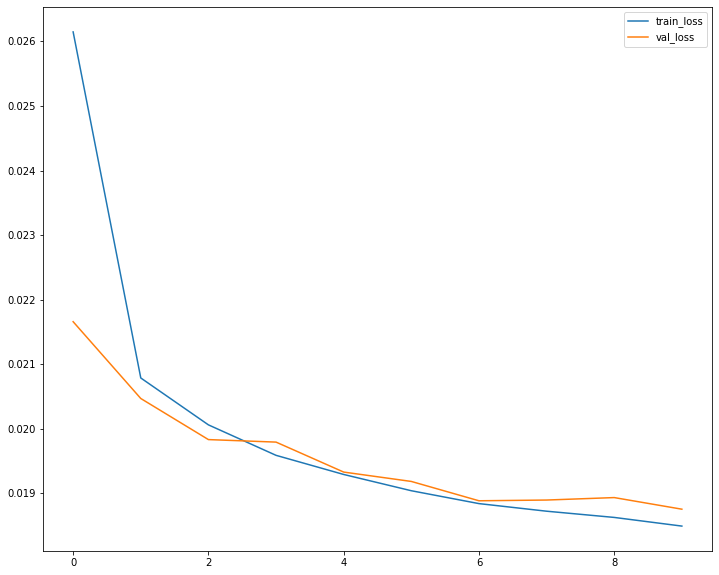

In [ ]:
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend();

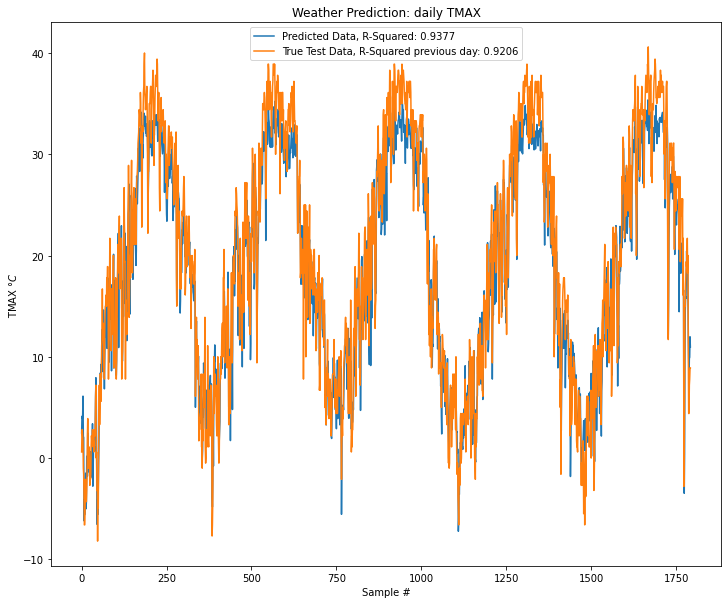

In [ ]:
#test predictions
test_predict=model.predict(test_data)

#For TMAX
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,0], test_predict[:,0])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,0], test_label[:-1,0])[0,1]**2

#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,0]*adj['TMAX'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,0]*adj['TMAX'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily TMAX")
ax.set_xlabel("Sample #")
ax.set_ylabel("TMAX $\degree C$")
ax.legend();

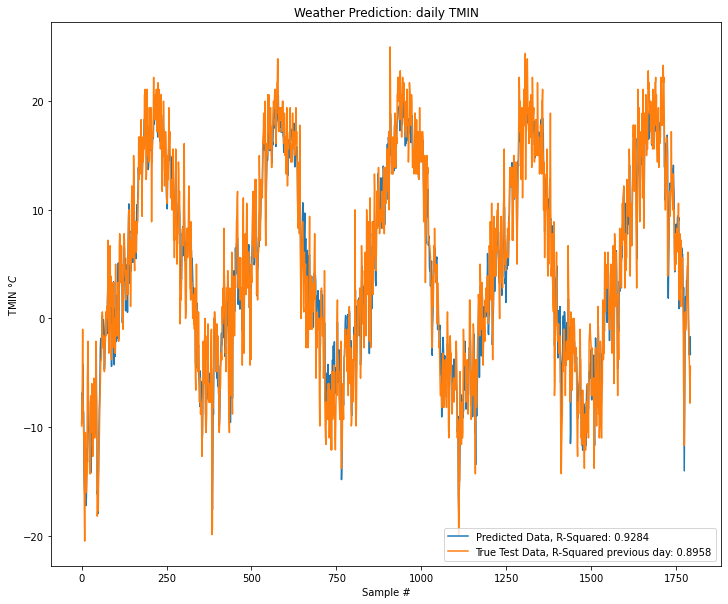

In [ ]:
#For TMIN
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,1], test_predict[:,1])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,1], test_label[:-1,1])[0,1]**2
#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,1]*adj['TMIN'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,1]*adj['TMIN'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily TMIN")
ax.set_xlabel("Sample #")
ax.set_ylabel("TMIN $\degree C$")
ax.legend();

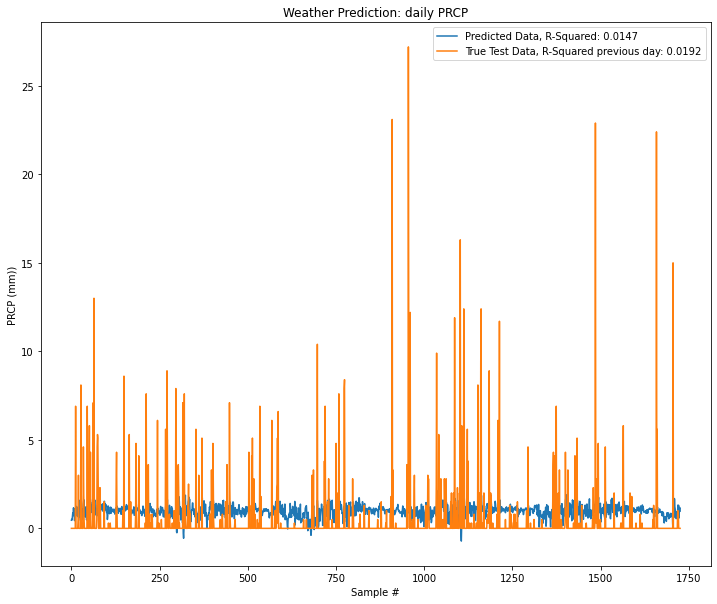

In [ ]:
#For PRCP
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,2], test_predict[:,2])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,2], test_label[:-1,2])[0,1]**2
#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,2]*adj['PRCP'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,2]*adj['PRCP'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily PRCP")
ax.set_xlabel("Sample #")
ax.set_ylabel("PRCP (mm))")
ax.legend();

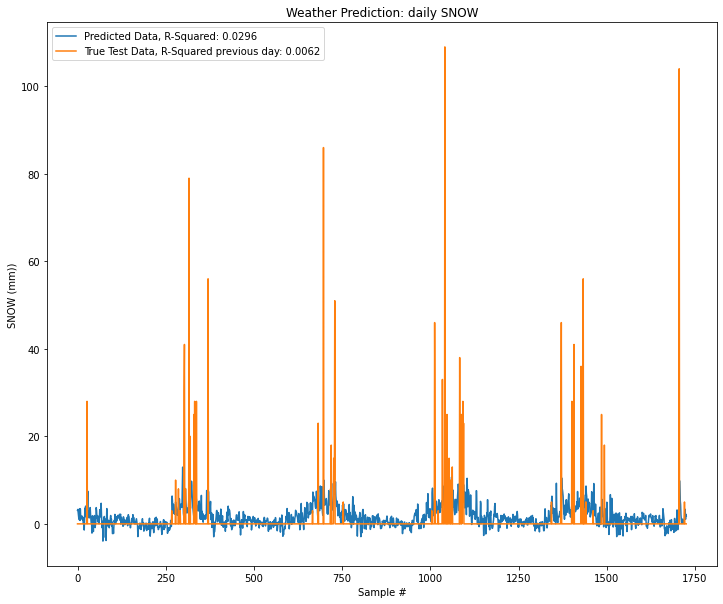

In [ ]:
#For SNOW
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,3], test_predict[:,3])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,3], test_label[:-1,3])[0,1]**2
#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,3]*adj['SNOW'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,3]*adj['SNOW'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily SNOW")
ax.set_xlabel("Sample #")
ax.set_ylabel("SNOW (mm))")
ax.legend();


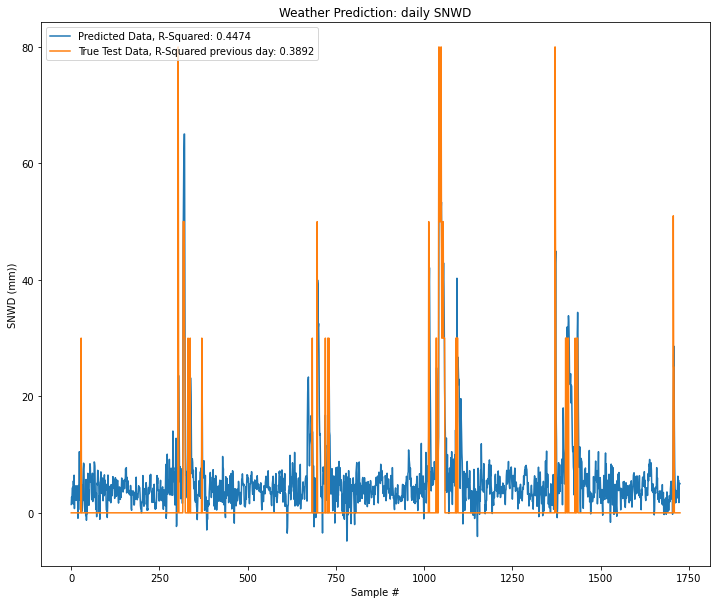

In [ ]:
#For SNWD
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,4], test_predict[:,4])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,4], test_label[:-1,4])[0,1]**2
#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,4]*adj['SNWD'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,4]*adj['SNWD'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily SNWD")
ax.set_xlabel("Sample #")
ax.set_ylabel("SNWD (mm))")
ax.legend();


## Task VIII. continued
The key results of different runs were recorded in Excel, and are summarised at the end of this notebook.


In [ ]:
#gamma model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(256,input_shape=(n_ts,dly_10.shape[1]),return_sequences=True))
model.add(keras.layers.Conv1D(32, (10), activation='relu', input_shape=(None, 365, 64)))
model.add(keras.layers.LSTM(256,activation='relu'))
model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.Dense(dly_10.shape[1],activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 30, 256)           304128    
                                                                 
 conv1d (Conv1D)             (None, 21, 32)            81952     
                                                                 
 lstm_15 (LSTM)              (None, 256)               295936    
                                                                 
 dense_14 (Dense)            (None, 64)                16448     
                                                                 
 dense_15 (Dense)            (None, 40)                2600      
                                                                 
Total params: 701,064
Trainable params: 701,064
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#delta model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(256,input_shape=(n_ts,dly_10.shape[1]),return_sequences=True))
#model.add(keras.layers.Conv1D(32, (10), activation='relu', input_shape=(None, 365, 64)))
model.add(keras.layers.LSTM(256,activation='relu'))
model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.Dense(dly_10.shape[1],activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 30, 256)           304128    
                                                                 
 lstm_17 (LSTM)              (None, 256)               525312    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 40)                2600      
                                                                 
Total params: 848,488
Trainable params: 848,488
Non-tr

In [ ]:
#epsilon model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(256,input_shape=(n_ts,dly_10.shape[1]),return_sequences=True))
model.add(keras.layers.Conv1D(32, (10), activation='relu', input_shape=(None, 365, 64)))
model.add(keras.layers.LSTM(256,activation='relu'))
#model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.Dense(64,activation='relu'))
#model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.Dense(dly_10.shape[1],activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 30, 256)           304128    
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 32)            81952     
                                                                 
 lstm_19 (LSTM)              (None, 256)               295936    
                                                                 
 dense_18 (Dense)            (None, 64)                16448     
                                                                 
 dense_19 (Dense)            (None, 40)                2600      
                                                                 
Total params: 701,064
Trainable params: 701,064
Non-trainable params: 0
_________________________________________________________________


## Task VIII. continued
Now, it was decided to see if the results would change by just using the single station. That had not been tried before for weather and was done for completeness and using the same date range as when working with four stations. Much of the following code is very similar to that already used.

In [ ]:
#For Colorado- replicating earlier cells so can run separately instead of re-running whole script
filename = 'USW00023066.dly'
dly = read_ghcn_data_file(filename=filename)
#drop MFLAG and QFLAG column
dly.drop(('MFLAG'), axis = 1, inplace = True)
dly.drop(('QFLAG'), axis = 1, inplace = True)

#drop VAR_TYPE column hierarchy as no longer needed 
dly_10 = dly.droplevel('VAR_TYPE',axis= 1)

#select the desired 10 columns
dly_10 = dly_10[['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5','WSF2','WSF5']]
dly_10 = dly_10[dly_10.index >= '1996-04-01 00:00:00']

dly_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8994 entries, 1996-04-01 to 2020-11-14
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8994 non-null   float64
 1   TMIN    8994 non-null   float64
 2   PRCP    8994 non-null   float64
 3   SNOW    8993 non-null   float64
 4   SNWD    8992 non-null   float64
 5   AWND    8988 non-null   float64
 6   WDF2    8991 non-null   float64
 7   WDF5    8974 non-null   float64
 8   WSF2    8991 non-null   float64
 9   WSF5    8974 non-null   float64
dtypes: float64(10)
memory usage: 772.9 KB


In [ ]:
#fill forward and replace extreme value as before
dly_10.fillna(method='ffill', inplace = True)
av = np.mean([76,103,94,98])
#replace 4095.0 with av
#NB is safe to do so as 4095.0 is outside ranges of all other elements
dly_10.replace(4095.0, av, inplace = True)
dly_10.describe()


ELEMENT,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,WDF2,WDF5,WSF2,WSF5
count,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000
mean,19.324194,4.649922,0.627374,1.210140,4.365577,33.157216,191.954080,201.101290,89.188654,109.286747
std,11.837798,9.713334,2.180278,8.323179,18.854957,13.591177,96.692829,95.694897,32.979833,43.797287
min,-11.700000,-26.700000,0.000000,0.000000,0.000000,3.000000,5.000000,5.000000,22.000000,27.000000
25%,9.400000,-2.800000,0.000000,0.000000,0.000000,23.000000,120.000000,120.000000,67.000000,76.000000
50%,20.000000,4.400000,0.000000,0.000000,0.000000,31.000000,160.000000,190.000000,80.000000,98.000000
75%,30.000000,13.300000,0.000000,0.000000,0.000000,41.000000,300.000000,300.000000,107.000000,134.000000
max,41.100000,25.600000,33.300000,183.000000,203.000000,105.000000,360.000000,360.000000,255.000000,326.000000


In [ ]:
dly_10, adj = normalise(dly_10)

In [ ]:
offset=0#predict one day forward
n_ts=365 #1 years of daily data for training
nn_df=make_offset_dataframe(dly_10,n_ts,offset)
nn_df.dropna(axis=0, inplace=True)#lose rows with NaN
#check
nn_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8629 entries, 1997-04-01 to 2020-11-14
Columns: 3660 entries, (0, 'TMAX') to ('label', 'WSF5')
dtypes: float64(3660)
memory usage: 241.0 MB


In [ ]:
nn_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,label
,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,...,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5,WSF5
count,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,...,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000
mean,0.469437,0.469410,0.469390,0.469383,0.469380,0.469369,0.469347,0.469308,0.469265,0.469211,0.469172,0.469143,0.469115,0.469125,0.469125,0.469089,0.469039,0.468998,0.468971,0.468962,0.468951,0.468943,0.468921,0.468879,0.468822,0.468777,0.468720,0.468670,0.468661,0.468633,0.468567,0.468503,0.468431,0.468357,0.468288,0.468225,0.468163,0.468087,0.468011,0.467961,...,0.335864,0.335862,0.335859,0.335864,0.335864,0.335918,0.335919,0.335902,0.335907,0.335913,0.335910,0.335889,0.335894,0.335893,0.335885,0.335893,0.335907,0.335909,0.335913,0.335947,0.335940,0.335931,0.335926,0.335905,0.335894,0.335864,0.335869,0.335871,0.335871,0.335868,0.335868,0.335871,0.335885,0.335916,0.335938,0.335908,0.335895,0.335883,0.335895,0.335868
std,0.287337,0.287335,0.287337,0.287339,0.287340,0.287344,0.287352,0.287366,0.287372,0.287380,0.287394,0.287422,0.287445,0.287437,0.287437,0.287466,0.287494,0.287516,0.287533,0.287540,0.287549,0.287554,0.287566,0.287575,0.287582,0.287603,0.287632,0.287650,0.287658,0.287677,0.287710,0.287747,0.287779,0.287814,0.287836,0.287847,0.287854,0.287867,0.287889,0.287907,...,0.134734,0.134734,0.134736,0.134732,0.134732,0.134769,0.134768,0.134769,0.134772,0.134769,0.134770,0.134776,0.134776,0.134777,0.134783,0.134778,0.134787,0.134785,0.134782,0.134803,0.134802,0.134795,0.134795,0.134799,0.134803,0.134803,0.134799,0.134797,0.134797,0.134800,0.134800,0.134803,0.134839,0.134848,0.134844,0.134817,0.134806,0.134809,0.134810,0.134774
min,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,...,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822,0.082822
25%,0.228710,0.228710,0.228710,0.228710,0.228710,0.228710,0.228710,0.228710,0.228710,0.228710,0.228710,0.228710,0.228710,0.

In [ ]:
#alpha model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(64,input_shape=(n_ts,dly_10.shape[1]),return_sequences=True))
model.add(keras.layers.LSTM(32,activation='relu'))
model.add(keras.layers.Dense(32,activation='relu'))
model.add(keras.layers.Dense(dly_10.shape[1],activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

history=model.fit(train_data,train_label,epochs=10,batch_size=10,verbose=1,validation_data=(val_data,val_label))


train_data (5177, 365, 10)
val_data (1726, 365, 10)
test_data (1726, 365, 10)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 365, 64)           19200     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 33,002
Trainable params: 33,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
518/518 [==============================] - 149s 282ms/step - loss: 0.0261 - val_loss: 0.0209


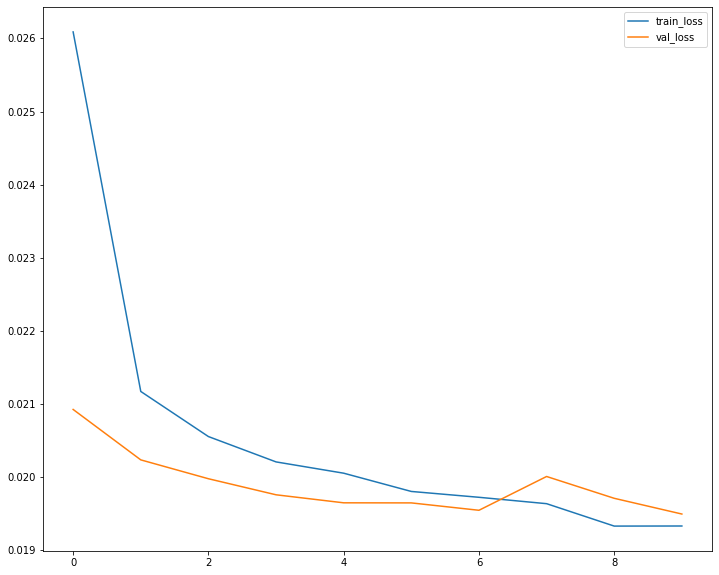

In [ ]:
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend();

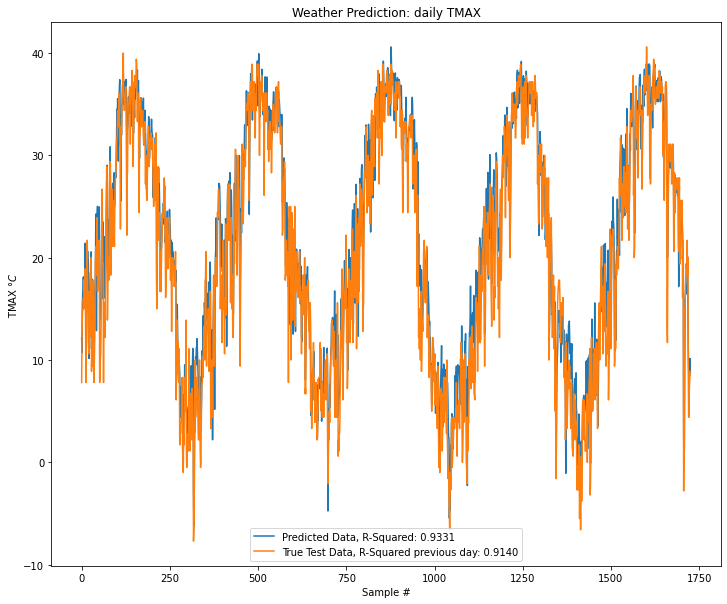

In [ ]:
#test predictions
test_predict=model.predict(test_data)

#For TMAX
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,0], test_predict[:,0])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,0], test_label[:-1,0])[0,1]**2

#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,0]*adj['TMAX'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,0]*adj['TMAX'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily TMAX")
ax.set_xlabel("Sample #")
ax.set_ylabel("TMAX $\degree C$")
ax.legend();

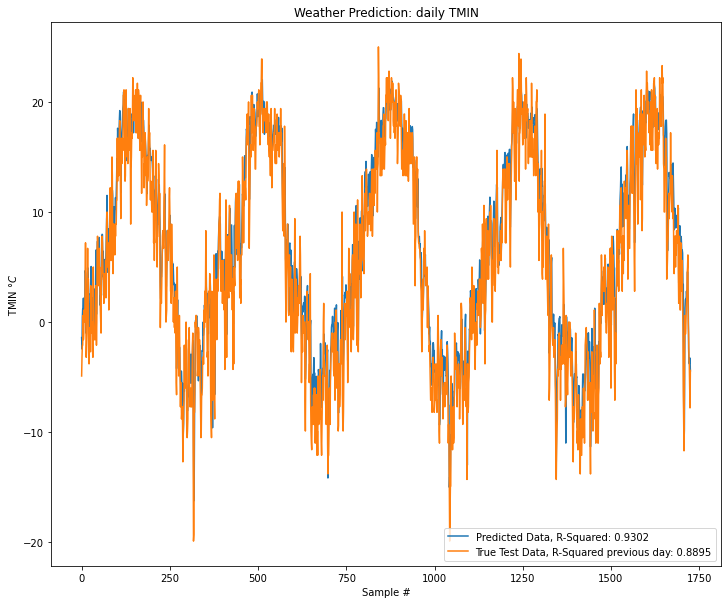

In [ ]:
#For TMIN
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,1], test_predict[:,1])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,1], test_label[:-1,1])[0,1]**2
#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,1]*adj['TMIN'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,1]*adj['TMIN'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily TMIN")
ax.set_xlabel("Sample #")
ax.set_ylabel("TMIN $\degree C$")
ax.legend();

#Task VIII.
Now this was repeated using just the two temperature elements.

In [ ]:
#For Colorado- replicating earlier cells so can run separately instead of re-running whole script
filename = 'USW00023066.dly'
dly = read_ghcn_data_file(filename=filename)
#drop MFLAG and QFLAG column
dly.drop(('MFLAG'), axis = 1, inplace = True)
dly.drop(('QFLAG'), axis = 1, inplace = True)

#drop VAR_TYPE column hierarchy as no longer needed 
dly_10 = dly.droplevel('VAR_TYPE',axis= 1)

#select the desired 10 columns
dly_10 = dly_10[['TMAX', 'TMIN']]
dly_10 = dly_10[dly_10.index >= '1996-04-01 00:00:00']

dly_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8994 entries, 1996-04-01 to 2020-11-14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8994 non-null   float64
 1   TMIN    8994 non-null   float64
dtypes: float64(2)
memory usage: 210.8 KB


In [ ]:
dly_10.describe()

ELEMENT,TMAX,TMIN
count,8994.000000,8994.000000
mean,19.324194,4.649922
std,11.837798,9.713334
min,-11.700000,-26.700000
25%,9.400000,-2.800000
50%,20.000000,4.400000
75%,30.000000,13.300000
max,41.100000,25.600000


In [ ]:
dly_10, adj = normalise(dly_10)

In [ ]:
offset=0#predict one day forward
n_ts=365 #1 years of daily data for training
nn_df=make_offset_dataframe(dly_10,n_ts,offset)
nn_df.dropna(axis=0, inplace=True)#lose rows with NaN
#check
nn_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8629 entries, 1997-04-01 to 2020-11-14
Columns: 732 entries, (0, 'TMAX') to ('label', 'TMIN')
dtypes: float64(732)
memory usage: 48.3 MB


In [ ]:
nn_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,label
,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,...,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN
count,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,...,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000
mean,0.469437,0.469410,0.469390,0.469383,0.469380,0.469369,0.469347,0.469308,0.469265,0.469211,0.469172,0.469143,0.469115,0.469125,0.469125,0.469089,0.469039,0.468998,0.468971,0.468962,0.468951,0.468943,0.468921,0.468879,0.468822,0.468777,0.468720,0.468670,0.468661,0.468633,0.468567,0.468503,0.468431,0.468357,0.468288,0.468225,0.468163,0.468087,0.468011,0.467961,...,0.181043,0.181111,0.181174,0.181224,0.181300,0.181360,0.181408,0.181423,0.181473,0.181544,0.181579,0.181611,0.181667,0.181725,0.181768,0.181818,0.181846,0.181876,0.181896,0.181866,0.181831,0.181780,0.181785,0.181778,0.181743,0.181720,0.181722,0.181728,0.181728,0.181718,0.181730,0.181735,0.181768,0.181798,0.181801,0.181791,0.181793,0.181765,0.181732,0.181682
std,0.287337,0.287335,0.287337,0.287339,0.287340,0.287344,0.287352,0.287366,0.287372,0.287380,0.287394,0.287422,0.287445,0.287437,0.287437,0.287466,0.287494,0.287516,0.287533,0.287540,0.287549,0.287554,0.287566,0.287575,0.287582,0.287603,0.287632,0.287650,0.287658,0.287677,0.287710,0.287747,0.287779,0.287814,0.287836,0.287847,0.287854,0.287867,0.287889,0.287907,...,0.380769,0.380735,0.380706,0.380694,0.380675,0.380633,0.380592,0.380589,0.380577,0.380523,0.380496,0.380472,0.380452,0.380416,0.380387,0.380360,0.380354,0.380334,0.380319,0.380342,0.380377,0.380433,0.380427,0.380431,0.380432,0.380439,0.380438,0.380435,0.380435,0.380437,0.380435,0.380435,0.380427,0.380403,0.380401,0.380408,0.380406,0.380426,0.380456,0.380474
min,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,...,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969
25%,0.228710,0.228710,0.228710,0.228710,0.228710,0.228710,0.228710,0.228710,0.22871

In [ ]:
train_data, val_data, test_data, train_label, val_label, test_label = dataset_split(nn_df)

#alpha model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(64,input_shape=(n_ts,dly_10.shape[1]),return_sequences=True))
model.add(keras.layers.LSTM(32,activation='relu'))
model.add(keras.layers.Dense(32,activation='relu'))
model.add(keras.layers.Dense(dly_10.shape[1],activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

history=model.fit(train_data,train_label,epochs=10,batch_size=10,verbose=1,validation_data=(val_data,val_label))


train_data (5177, 365, 2)
val_data (1726, 365, 2)
test_data (1726, 365, 2)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 365, 64)           17152     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 30,690
Trainable params: 30,690
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
518/518 [==============================] - 149s 282ms/step - loss: 0.0209 - val_loss: 0.0132
Epo

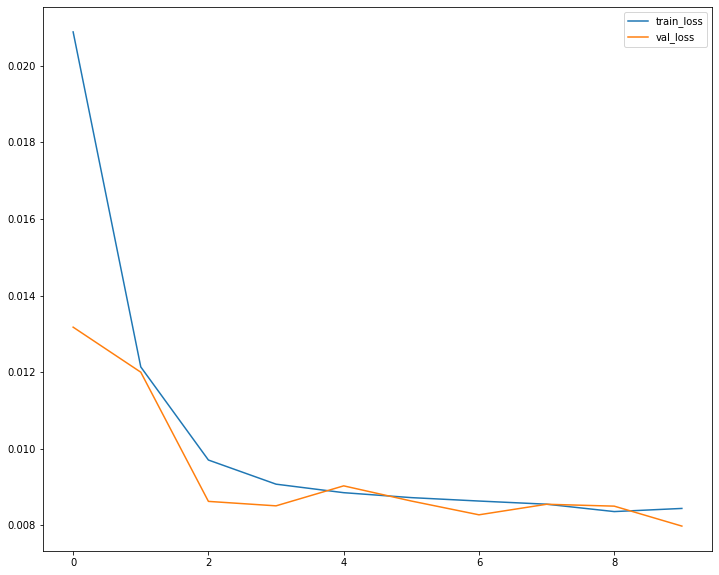

In [ ]:
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend();

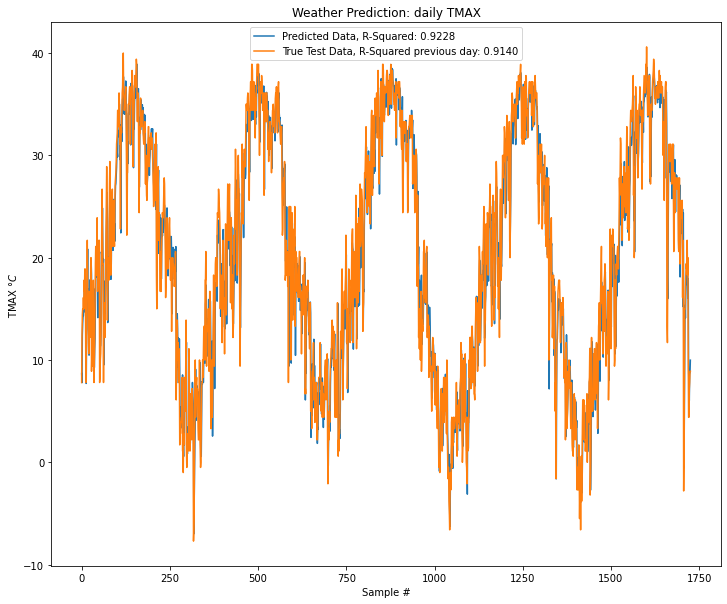

In [ ]:
#test predictions
test_predict=model.predict(test_data)

#For TMAX
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,0], test_predict[:,0])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,0], test_label[:-1,0])[0,1]**2

#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,0]*adj['TMAX'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,0]*adj['TMAX'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily TMAX")
ax.set_xlabel("Sample #")
ax.set_ylabel("TMAX $\degree C$")
ax.legend();

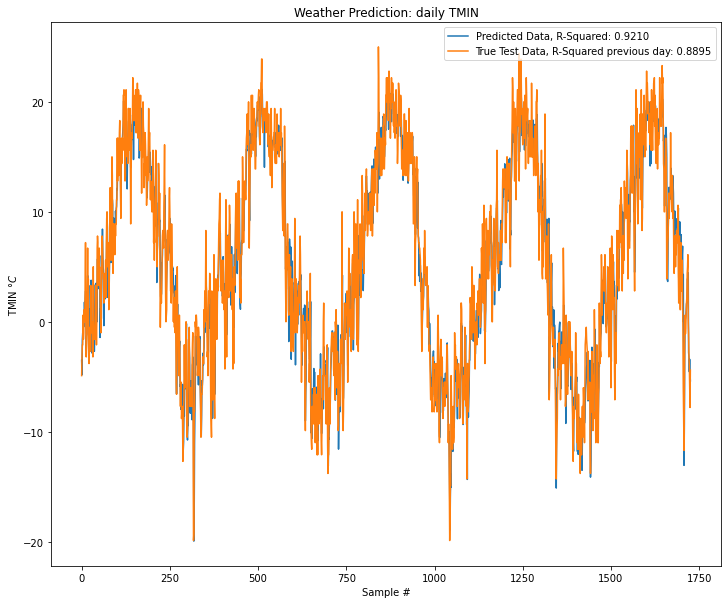

In [ ]:
#For TMIN
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,1], test_predict[:,1])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,1], test_label[:-1,1])[0,1]**2
#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,1]*adj['TMIN'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,1]*adj['TMIN'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily TMIN")
ax.set_xlabel("Sample #")
ax.set_ylabel("TMIN $\degree C$")
ax.legend();

#Task VIII. continued.
As final test, it was decided to run 4 stations, 2 features and 30 days.

In [ ]:
#For Colorado- replicating earlier cells so can run separately instead of re-running whole script
filename = 'USW00023066.dly'
dly = read_ghcn_data_file(filename=filename)
#drop MFLAG and QFLAG column
dly.drop(('MFLAG'), axis = 1, inplace = True)
dly.drop(('QFLAG'), axis = 1, inplace = True)

#drop VAR_TYPE column hierarchy as no longer needed 
dly_10 = dly.droplevel('VAR_TYPE',axis= 1)

#select the desired 10 columns
dly_10 = dly_10[['TMAX', 'TMIN']]
dly_10 = dly_10[dly_10.index >= '1996-04-01 00:00:00']

dly_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8994 entries, 1996-04-01 to 2020-11-14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8994 non-null   float64
 1   TMIN    8994 non-null   float64
dtypes: float64(2)
memory usage: 210.8 KB


In [ ]:
#For Oklahoma
filename = 'USW00013967.dly'
dlyOK = read_ghcn_data_file(filename=filename)
#drop MFLAG and QFLAG column
dlyOK.drop(('MFLAG'), axis = 1, inplace = True)
dlyOK.drop(('QFLAG'), axis = 1, inplace = True)

#drop VAR_TYPE column hierarchy as no longer needed 
dlyOK_10 = dlyOK.droplevel('VAR_TYPE',axis= 1)

#select the desired 10 columns
dlyOK_10 = dlyOK_10[['TMAX', 'TMIN']]
dlyOK_10 = dlyOK_10[dlyOK_10.index >= '1996-04-01 00:00:00']

dlyOK_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8990 entries, 1996-04-01 to 2020-11-14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8990 non-null   float64
 1   TMIN    8990 non-null   float64
dtypes: float64(2)
memory usage: 210.7 KB


In [ ]:
#For New Mexico
filename = 'USW00023050.dly'
dlyNM = read_ghcn_data_file(filename=filename)
#drop MFLAG and QFLAG column
dlyNM.drop(('MFLAG'), axis = 1, inplace = True)
dlyNM.drop(('QFLAG'), axis = 1, inplace = True)

#drop VAR_TYPE column hierarchy as no longer needed 
dlyNM_10 = dlyNM.droplevel('VAR_TYPE',axis= 1)

#select the desired 10 columns
dlyNM_10 = dlyNM_10[['TMAX', 'TMIN']]
dlyNM_10 = dlyNM_10[dlyNM_10.index >= '1996-04-01 00:00:00']

dlyNM_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8990 entries, 1996-04-01 to 2020-11-14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8990 non-null   float64
 1   TMIN    8990 non-null   float64
dtypes: float64(2)
memory usage: 210.7 KB


In [ ]:
#For Nebraska
filename = 'USW00024023.dly'
dlyNE = read_ghcn_data_file(filename=filename)
#drop MFLAG and QFLAG column
dlyNE.drop(('MFLAG'), axis = 1, inplace = True)
dlyNE.drop(('QFLAG'), axis = 1, inplace = True)

#drop VAR_TYPE column hierarchy as no longer needed 
dlyNE_10 = dlyNE.droplevel('VAR_TYPE',axis= 1)

#select the desired 10 columns
dlyNE_10 = dlyNE_10[['TMAX', 'TMIN']]
dlyNE_10 = dlyNE_10[dlyNE_10.index >= '1996-04-01 00:00:00']

dlyNE_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8994 entries, 1996-04-01 to 2020-11-14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8994 non-null   float64
 1   TMIN    8994 non-null   float64
dtypes: float64(2)
memory usage: 210.8 KB


In [ ]:
#adapted from https://www.pythonprogramming.in/how-to-add-row-to-dataframe-with-time-stamp-index-in-pandas.html

for i in ['2020-10-28 00:00:00', '2020-10-29 00:00:00', '2020-10-30 00:00:00', '2020-10-31 00:00:00']:
  line = pd.to_datetime(i, format="%Y-%m-%d %H:%M:%S")
  new_row = pd.DataFrame(columns=['TMAX', 'TMIN'], index=[line])
  dlyOK_10 = pd.concat([dlyOK_10, pd.DataFrame(new_row)], ignore_index=False)
  dlyNM_10 = pd.concat([dlyNM_10, pd.DataFrame(new_row)], ignore_index=False)

In [ ]:
dlyOK_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8994 entries, 1996-04-01 to 2020-10-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8990 non-null   float64
 1   TMIN    8990 non-null   float64
dtypes: float64(2)
memory usage: 210.8 KB


In [ ]:
dlyNM_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8994 entries, 1996-04-01 to 2020-10-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8990 non-null   float64
 1   TMIN    8990 non-null   float64
dtypes: float64(2)
memory usage: 210.8 KB


In [ ]:
#fill forward
dlyOK_10.fillna(method='ffill', inplace = True)
dlyOK_10.describe()

ELEMENT,TMAX,TMIN
count,8994.000000,8994.000000
mean,22.657294,10.228664
std,10.168416,9.625214
min,-9.400000,-20.600000
25%,15.600000,2.200000
50%,23.900000,11.100000
75%,31.100000,19.400000
max,45.000000,28.900000


In [ ]:
#rename so we can concatenate
dlyOK_10.rename(columns={"TMAX": "TMAXok", "TMIN": "TMINok"}, inplace=True)
dlyOK_10.head(1)

ELEMENT,TMAXok,TMINok
1996-04-01,19.4,2.2


In [ ]:
#fill forward
dlyNM_10.fillna(method='ffill', inplace = True)
dlyNM_10.describe()

ELEMENT,TMAX,TMIN
count,8994.000000,8994.000000
mean,21.615944,7.894307
std,9.639201,8.680149
min,-12.800000,-21.700000
25%,13.300000,0.600000
50%,22.800000,7.800000
75%,30.000000,16.100000
max,40.600000,25.600000


In [ ]:
#rename so we can concatenate
dlyNM_10.rename(columns={"TMAX": "TMAXnm", "TMIN": "TMINnm"}, inplace=True)
dlyNM_10.head(1)

ELEMENT,TMAXnm,TMINnm
1996-04-01,23.9,5.0


In [ ]:
#fill forward
dlyNE_10.fillna(method='ffill', inplace = True)
dlyNE_10.describe()

ELEMENT,TMAX,TMIN
count,8994.000000,8994.000000
mean,17.919024,1.904937
std,11.710348,10.902464
min,-16.700000,-31.600000
25%,9.400000,-6.700000
50%,18.900000,1.100000
75%,27.800000,11.700000
max,42.200000,24.400000


In [ ]:
#rename so we can concatenate
dlyNE_10.rename(columns={"TMAX": "TMAXne", "TMIN": "TMINne"}, inplace=True)
dlyNE_10.head(1)

ELEMENT,TMAXne,TMINne
1996-04-01,20.6,0.6


In [ ]:
dly_10 = pd.concat([dly_10, dlyOK_10], axis =1)

In [ ]:
dly_10 = pd.concat([dly_10, dlyNM_10], axis =1)

In [ ]:
dly_10 = pd.concat([dly_10, dlyNE_10], axis =1)

In [ ]:
dly_10.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8994 entries, 1996-04-01 to 2020-11-14
Freq: D
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    8994 non-null   float64
 1   TMIN    8994 non-null   float64
 2   TMAXok  8994 non-null   float64
 3   TMINok  8994 non-null   float64
 4   TMAXnm  8994 non-null   float64
 5   TMINnm  8994 non-null   float64
 6   TMAXne  8994 non-null   float64
 7   TMINne  8994 non-null   float64
dtypes: float64(8)
memory usage: 632.4 KB


In [ ]:
dly_10.describe()

ELEMENT,TMAX,TMIN,TMAXok,TMINok,TMAXnm,TMINnm,TMAXne,TMINne
count,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000,8994.000000
mean,19.324194,4.649922,22.657294,10.228664,21.615944,7.894307,17.919024,1.904937
std,11.837798,9.713334,10.168416,9.625214,9.639201,8.680149,11.710348,10.902464
min,-11.700000,-26.700000,-9.400000,-20.600000,-12.800000,-21.700000,-16.700000,-31.600000
25%,9.400000,-2.800000,15.600000,2.200000,13.300000,0.600000,9.400000,-6.700000
50%,20.000000,4.400000,23.900000,11.100000,22.800000,7.800000,18.900000,1.100000
75%,30.000000,13.300000,31.100000,19.400000,30.000000,16.100000,27.800000,11.700000
max,41.100000,25.600000,45.000000,28.900000,40.600000,25.600000,42.200000,24.400000


In [ ]:
dly_10, adj = normalise(dly_10)

In [ ]:
offset=0#predict one day forward
n_ts=30 #1 years of daily data for training
nn_df=make_offset_dataframe(dly_10,n_ts,offset)
nn_df.dropna(axis=0, inplace=True)#lose rows with NaN
#check
nn_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8964 entries, 1996-05-01 to 2020-11-14
Freq: D
Columns: 248 entries, (0, 'TMAX') to ('label', 'TMINne')
dtypes: float64(248)
memory usage: 17.0 MB


In [ ]:
nn_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,label,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,label
,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMAX,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,TMIN,...,TMAXne,TMAXne,TMAXne,TMAXne,TMAXne,TMAXne,TMAXne,TMAXne,TMAXne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne,TMINne
count,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,...,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000,8964.000000
mean,0.470499,0.470483,0.470486,0.470511,0.470529,0.470548,0.470562,0.470571,0.470547,0.470532,0.470514,0.470473,0.470436,0.470436,0.470446,0.470443,0.470431,0.470426,0.470434,0.470452,0.470476,0.470500,0.470505,0.470493,0.470444,0.470397,0.470346,0.470301,0.470292,0.470272,0.470229,0.182296,0.182284,0.182258,0.182282,0.182299,0.182313,0.182335,0.182347,0.182330,...,0.424712,0.424725,0.424707,0.424703,0.424662,0.424644,0.424639,0.424641,0.424634,0.078743,0.078733,0.078751,0.078756,0.078780,0.078823,0.078869,0.078863,0.078823,0.078805,0.078754,0.078701,0.078640,0.078615,0.078612,0.078619,0.078619,0.078578,0.078525,0.078490,0.078500,0.078510,0.078559,0.078607,0.078630,0.078584,0.078558,0.078530,0.078492,0.078456,0.078441
std,0.288253,0.288249,0.288250,0.288254,0.288256,0.288257,0.288260,0.288263,0.288261,0.288254,0.288255,0.288305,0.288341,0.288341,0.288335,0.288336,0.288336,0.288336,0.288336,0.288330,0.288322,0.288318,0.288317,0.288314,0.288316,0.288341,0.288365,0.288379,0.288387,0.288398,0.288407,0.379743,0.379745,0.379747,0.379746,0.379743,0.379738,0.379733,0.379733,0.379734,...,0.277798,0.277806,0.277791,0.277791,0.277807,0.277810,0.277815,0.277814,0.277816,0.447225,0.447227,0.447222,0.447220,0.447209,0.447189,0.447169,0.447170,0.447190,0.447201,0.447227,0.447260,0.447317,0.447337,0.447338,0.447334,0.447334,0.447356,0.447358,0.447361,0.447359,0.447355,0.447340,0.447358,0.447368,0.447364,0.447376,0.447387,0.447406,0.447429,0.447434
min,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-0.284672,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,-1.042969,...,-0.395735,-0.395735,-0.395735,-0.395735,-0.395735,-0.395735,-0.395735,-0.395735,-0.395735,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082,-1.295082
25%,0.228710,0.228710,0.228710,0.228710,0.228710,0.2287

In [ ]:
train_data, val_data, test_data, train_label, val_label, test_label = dataset_split(nn_df)

#alpha model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(64,input_shape=(n_ts,dly_10.shape[1]),return_sequences=True))
model.add(keras.layers.LSTM(32,activation='relu'))
model.add(keras.layers.Dense(32,activation='relu'))
model.add(keras.layers.Dense(dly_10.shape[1],activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

history=model.fit(train_data,train_label,epochs=10,batch_size=10,verbose=1,validation_data=(val_data,val_label))


train_data (5378, 30, 8)
val_data (1793, 30, 8)
test_data (1793, 30, 8)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 30, 64)            18688     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 8)                 264       
                                                                 
Total params: 32,424
Trainable params: 32,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
538/538 [==============================] - 18s 29ms/step - loss: 0.0239 - val_loss: 0.0169
Epoch 2/

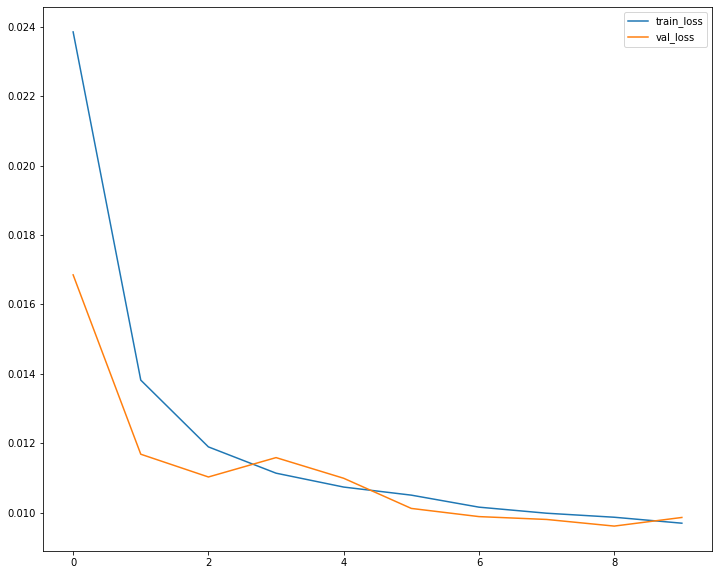

In [ ]:
fig,ax=plt.subplots()
ax.plot(history.history['loss'], label='train_loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.set_title = 'Loss of the model'
ax.xlabel = 'Time (Epochs)'
ax.ylabel = 'Loss'
ax.legend();

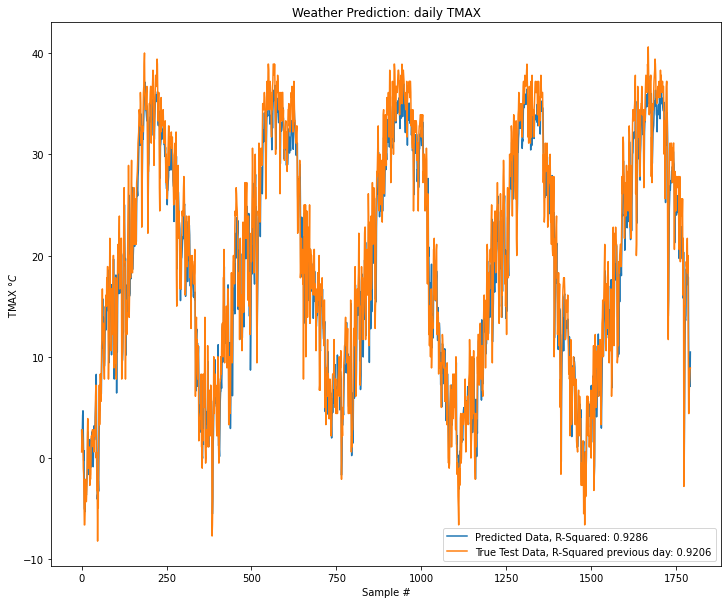

In [ ]:
#test predictions
test_predict=model.predict(test_data)

#For TMAX
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,0], test_predict[:,0])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,0], test_label[:-1,0])[0,1]**2

#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,0]*adj['TMAX'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,0]*adj['TMAX'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily TMAX")
ax.set_xlabel("Sample #")
ax.set_ylabel("TMAX $\degree C$")
ax.legend();

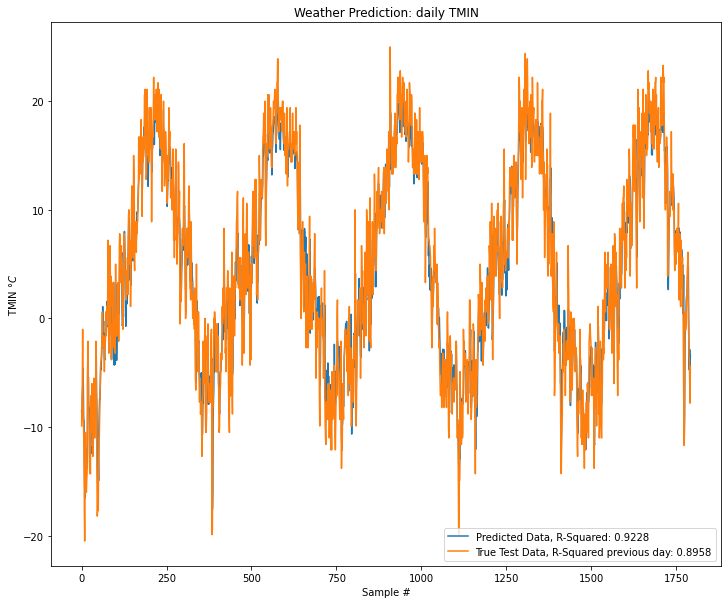

In [ ]:
#For TMIN
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,1], test_predict[:,1])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,1], test_label[:-1,1])[0,1]**2
#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,1]*adj['TMIN'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,1]*adj['TMIN'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily TMIN")
ax.set_xlabel("Sample #")
ax.set_ylabel("TMIN $\degree C$")
ax.legend();

#Task VIII. continued
Showing results for best combination: 1 station, 10 elements, 30 time steps, beta model. NB do not run code cells as intervening steps have been deleted for brevity. 

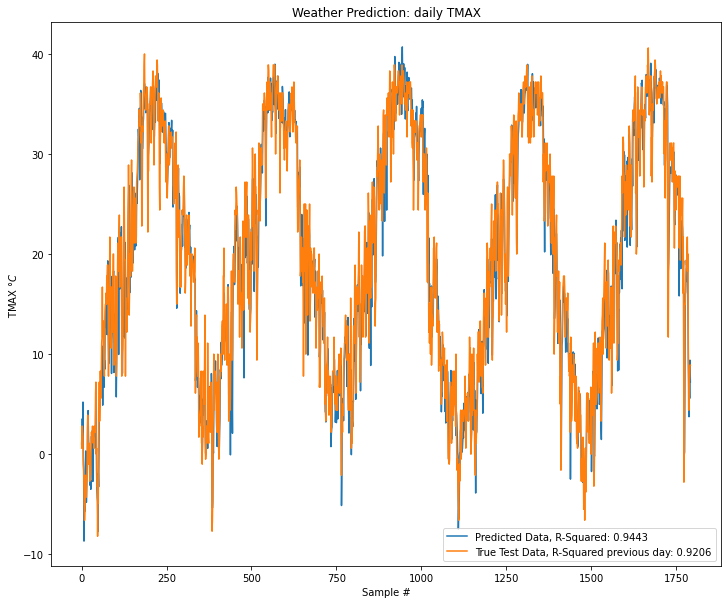

In [ ]:
#test predictions
test_predict=model.predict(test_data)

#For TMAX
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,0], test_predict[:,0])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,0], test_label[:-1,0])[0,1]**2

#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,0]*adj['TMAX'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,0]*adj['TMAX'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily TMAX")
ax.set_xlabel("Sample #")
ax.set_ylabel("TMAX $\degree C$")
ax.legend();

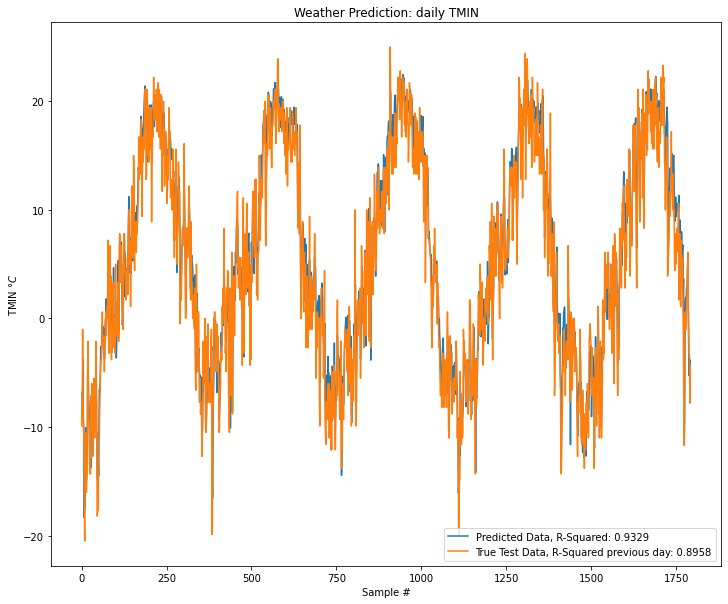

In [ ]:
#For TMIN
#R-squared with true values
Rsqr = np.corrcoef(test_label[:,1], test_predict[:,1])[0,1]**2

#R-squared with previous day
Rsqr2 = np.corrcoef(test_label[1:,1], test_label[:-1,1])[0,1]**2
#plot them
fig,ax=plt.subplots()
ax.plot(test_predict[offset:,1]*adj['TMIN'],label=f"Predicted Data, R-Squared: {Rsqr:0.4f}")
ax.plot(test_label[:,1]*adj['TMIN'],label=f"True Test Data, R-Squared previous day: {Rsqr2:0.4f}")
ax.set_title("Weather Prediction: daily TMIN")
ax.set_xlabel("Sample #")
ax.set_ylabel("TMIN $\degree C$")
ax.legend();

## Task VIII. continued.
Results were recorded in excel and are shown below for completeness

In [ ]:
results_order = ['stations', 'elements', 'timesteps', 'model', 'TMAX_RSqr', 'TMIN_RSqr']

results = [[4,2,30, 'alpha', 0.9286, 0.9288],
           [4,10,30, 'alpha', 0.9389, 0.9258],
           [4,10,365, 'alpha', 0.9322, 0.9204],
           [4,10,30,'beta', 0.9377, 0.9284],
           [4,10,30, 'gamma', 0.9158, 0.9105],
           [4,10,30, 'delta', 0.9302, 0.9195],
           [4,10,30, 'epsilon', 0.9364, 0.9210],
           [1,2,7,'alpha',0.9281,0.9248],
           [1,2,30,'alpha', 0.9291,0.9247],
           [1,2,365,'alpha', 0.9228,0.9210],
           [1,10,30, 'alpha', 0.9418,0.9330],
           [1,10,365, 'alpha', 0.9331,0.9302],
           [1,10,30, 'beta', 0.9443,0.9329]]
         

#Task VIII. continued
## Conclusions
<p>All models improved on today predicting tomorrow's temperature.
<p>30 days seemed to be the best of number of time steps tested.
<p>Increasing number of elements from just temperature to include precipitation, snow and wind data brought the largest improvement.
<p>Increasing to include data from 3 neighbouring stations worsened the model.
<p>Increasing the width of layers in networks increased performance slightly. 
<p>Beta was the best model tested, but did not improve much over the original and simpler alpha model.
<p>Adding in CNN and Dropout layers was unsuccessful and worsened performance.



## Task IX. Check the notebook for any opportunities to simplify. Make sure to annotate fully and with supporting text cells.
This has been checked and code streamlined by adding in functions, for example, normalise, dataset_split.


## Tasks X, XI
Completed